This notebook performs several analysis steps on the unnormalized posteriors computed by `save_posterior_table()`:
* Plots MC errors on $p_\gamma$;
* Normalizes the posteriors and saves the results to tables;
* Computes and saves 95% CI bounds on $\langle \sigma v \rangle$;
* Creates plots of these bounds overlayed on a color mesh of the unnormalized posteriors for DM mass.

$\langle \sigma v \rangle$ grid is too small for:
* `M=0.5, N=1, merger_rate_prior="LF", lambda_prior="LF", sv_prior="U"`
* `M=0.5, N=1, merger_rate_prior="J", lambda_prior="LF", sv_prior="U"`
* `M=10., N=1, merger_rate_prior="LF", lambda_prior="LF", sv_prior="U"`
* `M=10., N=1, merger_rate_prior="J", lambda_prior="LF", sv_prior="U"`

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm
from scipy.integrate import quad, trapz, cumtrapz
from scipy.interpolate import interp1d, interp2d, RectBivariateSpline
from scipy.optimize import root_scalar
from scipy.special import erfc
from scipy import stats

from constants import n_u_0, m_mw_dm, h_hubble, age_of_universe, yr_to_s, kpc_to_cm
from constants import m_sun_to_GeV, fermi_pt_src_sens_0_0, fermi_pt_src_sens_120_45
from constants import load_spec_interps, load_exp_tau_interp, rho_dm_avg_0, sci_fmt
from constants import rho_einasto, d_earth, r_s_mw, phi_g_egb_fermi, flux_thresh_0
from constants import int_dnde_interps, int_e_dnde_interps, GeV_to_erg, speed_of_light
from constants import h_hubble, Omega_m_0, Omega_Lambda_0, hubble

from pbhhalosim import PBHHaloSim
from posterior_inference import load_posterior, post_sv_dir, post_f_dir
from posterior_inference import save_normalized_posterior_table, save_sv_bounds
from posterior_inference import save_p_gamma_table, load_p_gamma
from diffuse_constraints import sv_bound_diff

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]
dnde_bb = load_spec_interps()["b"]

# Posterior analysis setup

In [3]:
m_pbh = 0.5
n_pbh = 81

# merger_rate_prior = "LF"  # conservative
merger_rate_prior = "J"  # optimistic
lambda_prior = "LF"  # conservative
sv_prior = "U"  # conservative

gambit_dir = "data/gambit/"
gambit_models = ["CMSSM", "MSSM7", "NUHM1", "NUHM2", "SingletDM"]

In [12]:
# Normalize the posteriors
save_normalized_posterior_table(m_pbh, n_pbh, merger_rate_prior, lambda_prior, sv_prior)

# Load unnormalized and normalized posteriors
svs, _, post_un_vals = load_posterior(m_pbh, n_pbh, merger_rate_prior,
                                      lambda_prior, sv_prior, normalized=False)
svs, _, post_vals = load_posterior(m_pbh, n_pbh, merger_rate_prior,
                                   lambda_prior, sv_prior, normalized=True)

# Compute <sigma v> bounds
m_dms, sv_bounds = save_sv_bounds(m_pbh, n_pbh, merger_rate_prior, lambda_prior, sv_prior)

# Get MAP estimate for f
experiment = "ET" if m_pbh == 10 else "O3"
fs, p_fs = np.loadtxt(
    "{}Posterior_f_{}_Prior_{}_M={:.1f}_N={}.txt".format(
        post_f_dir, experiment, merger_rate_prior, m_pbh, n_pbh)).T
f_map = fs[p_fs.argmax()]

# Point-source vs diffuse constraints

## Load backgrounds, observations, annihilation rate in UCMHs

In [5]:
# Observations
e_egb, phi_egb, err_low_egb, err_high_egb = np.loadtxt("data/egb_components/egb_obs.csv").T
phi_egb /= e_egb**2
err_low_egb = phi_egb - err_low_egb / e_egb**2
err_high_egb = err_high_egb / e_egb**2 - phi_egb

# Background components
e_b, phi_b = np.loadtxt("data/egb_components/blazars.csv").T
phi_b /= e_b**2
def phi_blazar_interp(e):
    return np.exp(np.interp(np.log(e), np.log(e_b), np.log(phi_b)))

e_m, phi_m = np.loadtxt("data/egb_components/m_agn.csv").T
phi_m /= e_m**2
def phi_m_agn_interp(e):
    return np.exp(np.interp(np.log(e), np.log(e_m), np.log(phi_m)))

e_s, phi_s = np.loadtxt("data/egb_components/sfg.csv").T
phi_s /= e_s**2
def phi_sfg_interp(e):
    return np.exp(np.interp(np.log(e), np.log(e_s), np.log(phi_s)))

# Total background
def phi_egb_bg(e, f_b=1, f_m=1, f_s=1):
    return f_b * phi_blazar_interp(e) + f_m * phi_m_agn_interp(e) + f_s * phi_sfg_interp(e)

# DM annihilation rate in UCMH
def Gamma_pbh(m_dm, sv, m_pbh):  # Hz
    rho_max = m_dm / (sv * age_of_universe * yr_to_s)  # GeV / cm^3
    r_cut = 1.3e-7 * h_hubble * (sv / 3e-26)**(4/9) * (m_dm / 100.)**(-4/9) * (m_pbh / 1.)**(1/3)  # kpc
    return 4*np.pi * sv * rho_max**2 * (r_cut * kpc_to_cm)**3 / (2*m_dm**2)  # Hz

## Fig. 2 from Shin'ichiro's paper

With each background components' normalization set to 1, the background model is in $>5\sigma$ tension with observations...

Text(0, 0.5, '$E^2 \\phi_\\gamma$ (GeV cm$^{-2}$ $s^{-1}$ sr$^{-1}$)')

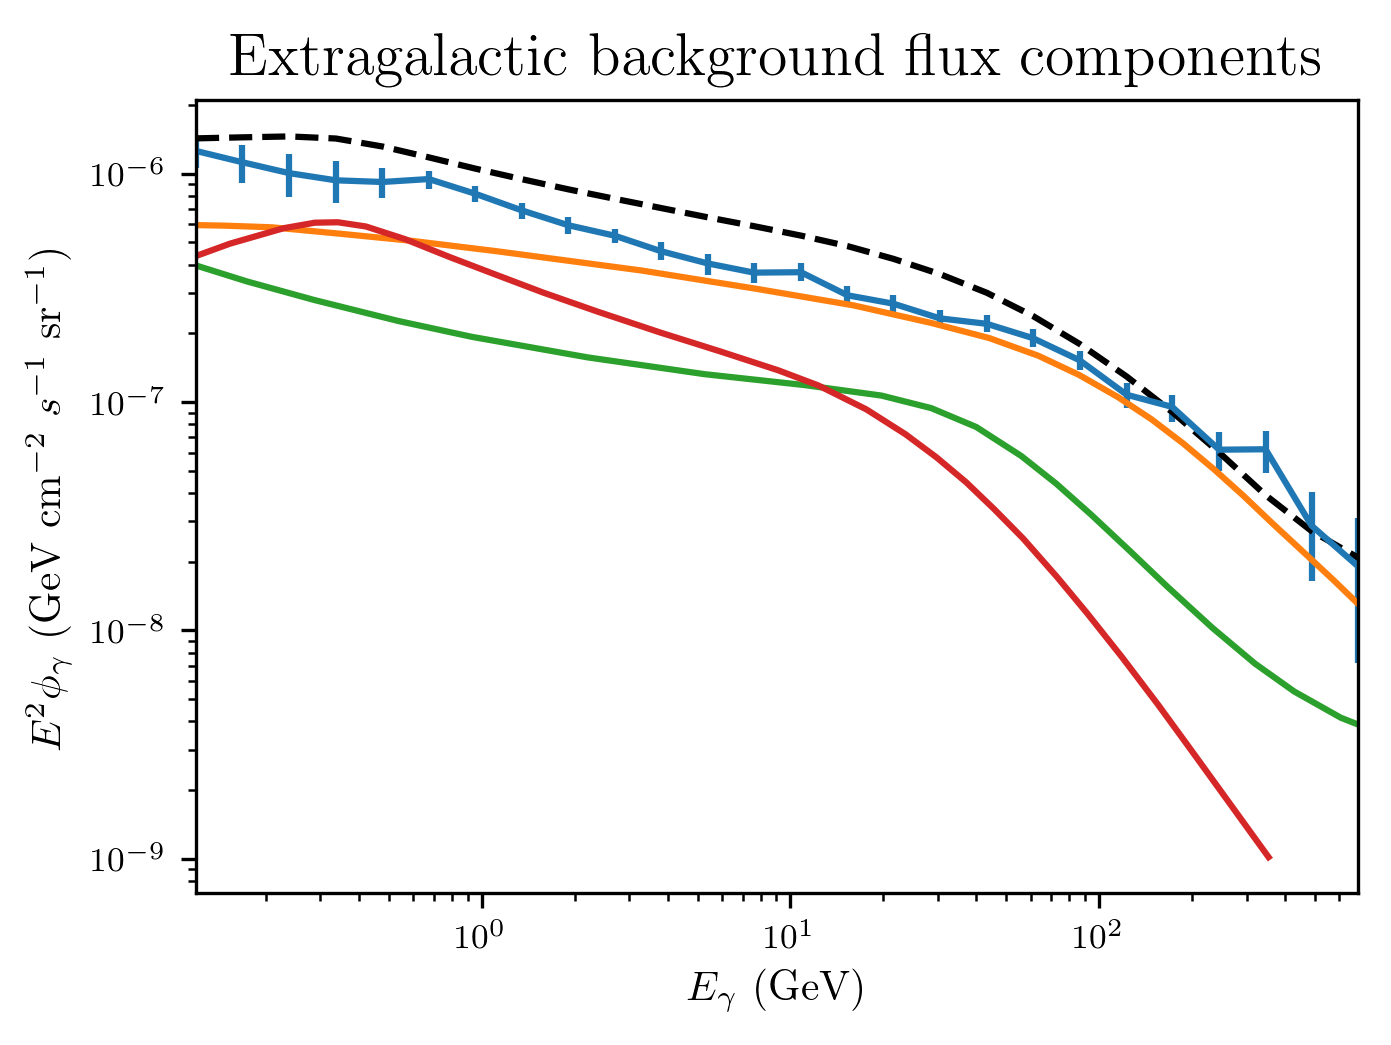

In [64]:
plt.xscale("log")
plt.yscale("log")
plt.xlim(e_egb[[0, -1]])
# plt.ylim(0, 1.5e-6)

plt.errorbar(e_egb, e_egb**2 * phi_egb, e_egb**2 * np.stack([err_low_egb, err_high_egb]),
             label="Obs.")
plt.plot(e_b, e_b**2 * phi_b, label="Blazars")
plt.plot(e_m, e_m**2 * phi_m, label="mAGN")
plt.plot(e_s, e_s**2 * phi_s, label="SFG")

plt.plot(e_egb, e_egb**2 * phi_egb_bg(e_egb), '--k', label="Total bg (fiducial)")

plt.title("Extragalactic background flux components")
plt.xlabel(r"$E_\gamma$ (GeV)")
plt.ylabel(r"$E^2 \phi_\gamma$ (GeV cm$^{-2}$ $s^{-1}$ sr$^{-1}$)")

## Diffuse constraint from [Chris Byrnes' paper](https://arxiv.org/abs/1901.08528)

The constraint is

$\Gamma_{\mathrm{DM}} \equiv \frac{f_{\mathrm{PBH}} \, m_{\mathrm{DM}} \, \Gamma_{\mathrm{PBH}}(\langle \sigma v \rangle)}{M_{\mathrm{PBH}}} < 10^{-28}~\mathrm{Hz} \equiv \Gamma_{\mathrm{DM}}^0.$

This can be solved analytically since $\Gamma_{\mathrm{PBH}}(\langle \sigma v \rangle) \propto \langle \sigma v \rangle^{1/3}$:

$\frac{\langle \sigma v \rangle}{\mathrm{cm}^3/\mathrm{s}} = \left[ \frac{f_{\mathrm{PBH}} \, m_{\mathrm{DM}} \, \Gamma_{\mathrm{PBH}}(1~\mathrm{cm}^3/\mathrm{s})}{M_{\mathrm{PBH}} \, \Gamma_{\mathrm{DM}}^0} \right]^{-3}.$

Things to look at:
* Why am I finding $f \sim 10^{-8}$ to be consistent with the thermal cross section rather than $f \sim 10^{-9}$?
* When computing the constraint (see [this paper](https://arxiv.org/abs/1712.06383)), how much does the galactic term contribute?

In [6]:
Gamma_dm_bound = 1e-28  # Hz

def sv_bound_diffuse(m_dm, m_pbh, f_pbh):  # cm^3 / s
    return (f_pbh * (1 - f_pbh)**2 * m_dm * Gamma_pbh(m_dm, 1., m_pbh) /
            (m_pbh*m_sun_to_GeV * Gamma_dm_bound))**(-3)

## Recomputing diffuse flux from UCMHs

In [7]:
# LOS integral away from GC
rho_los_int = quad(rho_einasto, d_earth, 1000*r_s_mw)[0]
# Interpolator for exp(-tau(e, z'))
exp_tau = load_exp_tau_interp()

def phi_gal(e, m_dm, sv, m_pbh, f):  # (GeV cm^2 sr s)^-1
    # 1 / kpc^2 / GeV / s
    return (f * (1 - f)**2 * Gamma_pbh(m_dm, sv, m_pbh) / m_pbh *
            rho_los_int / (4 * np.pi) * dnde_bb(e, m_dm).flatten()) / (kpc_to_cm)**2

def phi_ex(e, m_dm, sv, m_pbh, f):  # (GeV cm^2 sr s)^-1
    @np.vectorize
    def _phi_ex(e):
        def integrand(zp):
            return exp_tau(e, zp)[0] / hubble(zp) * dnde_bb((1 + zp) * e, m_dm)

        # integral = quad(integrand, 0, 1000, epsrel=1e-5, epsabs=0)[0]
        zps = np.logspace(0, 3, 1000)
        integral = trapz(integrand(zps), zps)

        return (speed_of_light * f * (1 - f)**2 * Gamma_pbh(m_dm, sv, m_pbh) / m_pbh *
                rho_dm_avg_0 / kpc_to_cm**2 * 1e3*integral / (4 * np.pi))

    return _phi_ex(e)

def phi_diff(e, m_dm, sv, m_pbh, f):  # (GeV cm^2 sr s)^-1
    return phi_gal(e, m_dm, sv, m_pbh, f) + phi_ex(e, m_dm, sv, m_pbh, f)

## Diffuse vs point-source constraints analysis

In [8]:
@np.vectorize
def sv_bound_pt(m_dm, m_pbh, f):
    """Computes the bound on <sigma v> by requiring not too many PBHs
    pass the Fermi point source cuts.
    """
    def objective(log10_sv):
        sim = PBHHaloSim(m_pbh, f, m_dm, 10**log10_sv, n_samples=10000)
        sim.run()
        return sim.n_det - n_u_0
    
    sol = root_scalar(objective, bracket=[-45, -20], maxiter=20)
    assert sol.converged == True
    return 10**sol.root

**Galactic and extragalatic contributions to the diffuse flux from PBHs.** The main contribution above about 1 GeV is galactic.

Text(0, 0.5, '$E^2 \\phi_\\gamma$ (GeV cm$^{-2}$ $s^{-1}$ sr$^{-1}$)')

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


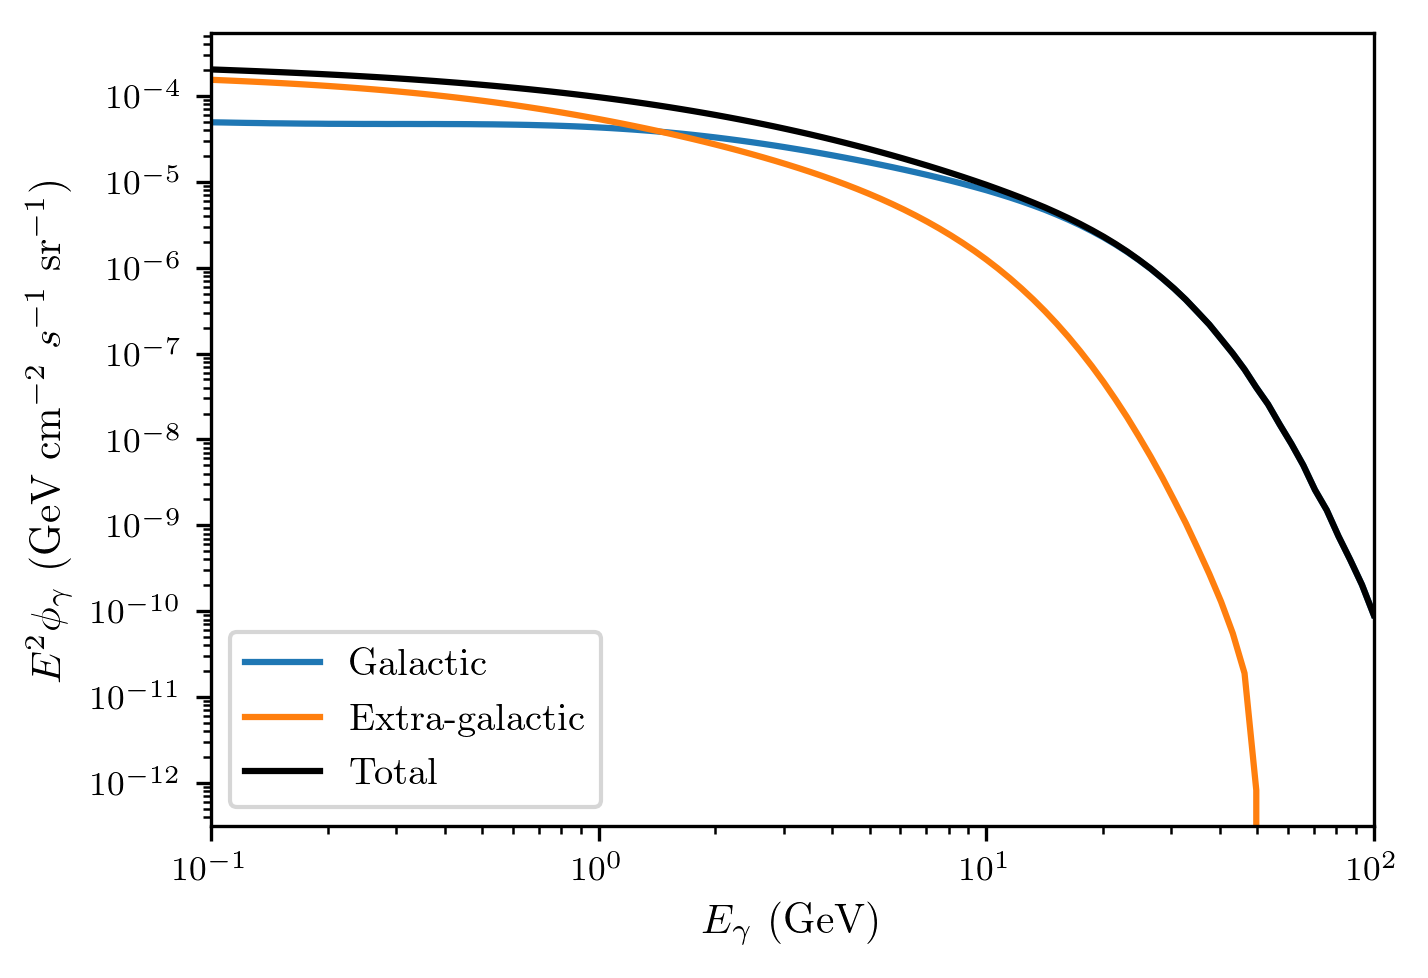

In [9]:
m_dm = 100.
sv = 1e-30

es = np.logspace(-1, np.log10(m_dm), 100)
plt.plot(es, phi_gal(es, m_dm, sv, m_pbh, f_map), label="Galactic")
plt.plot(es, phi_ex(es, m_dm, sv, m_pbh, f_map), label="Extra-galactic")
plt.plot(es, phi_diff(es, m_dm, sv, m_pbh, f_map), 'k', label="Total")

plt.xscale("log")
plt.yscale("log")
plt.xlim(es[[0, -1]])
plt.legend()
plt.xlabel(r"$E_\gamma$ (GeV)")
plt.ylabel(r"$E^2 \phi_\gamma$ (GeV cm$^{-2}$ $s^{-1}$ sr$^{-1}$)")

**Comparison of relevant integrated fluxes:** point-source threshold vs observed EGB integrated flux. These are within a factor of 2: the EGB flux is lower than the point-source threshold, which makes sense because the point source needs to be bright to be observable. This doesn't explain the big difference in the limits.

In [15]:
trapz(phi_egb[e_egb > 1.], e_egb[e_egb > 1.]), flux_thresh_0

(4.0096916544493366e-07, 7e-10)

**Limit comparison:** point-source and diffuse constraints on $\langle \sigma v \rangle$. As $f$ increases, the point-source constraint approaches the diffuse one.

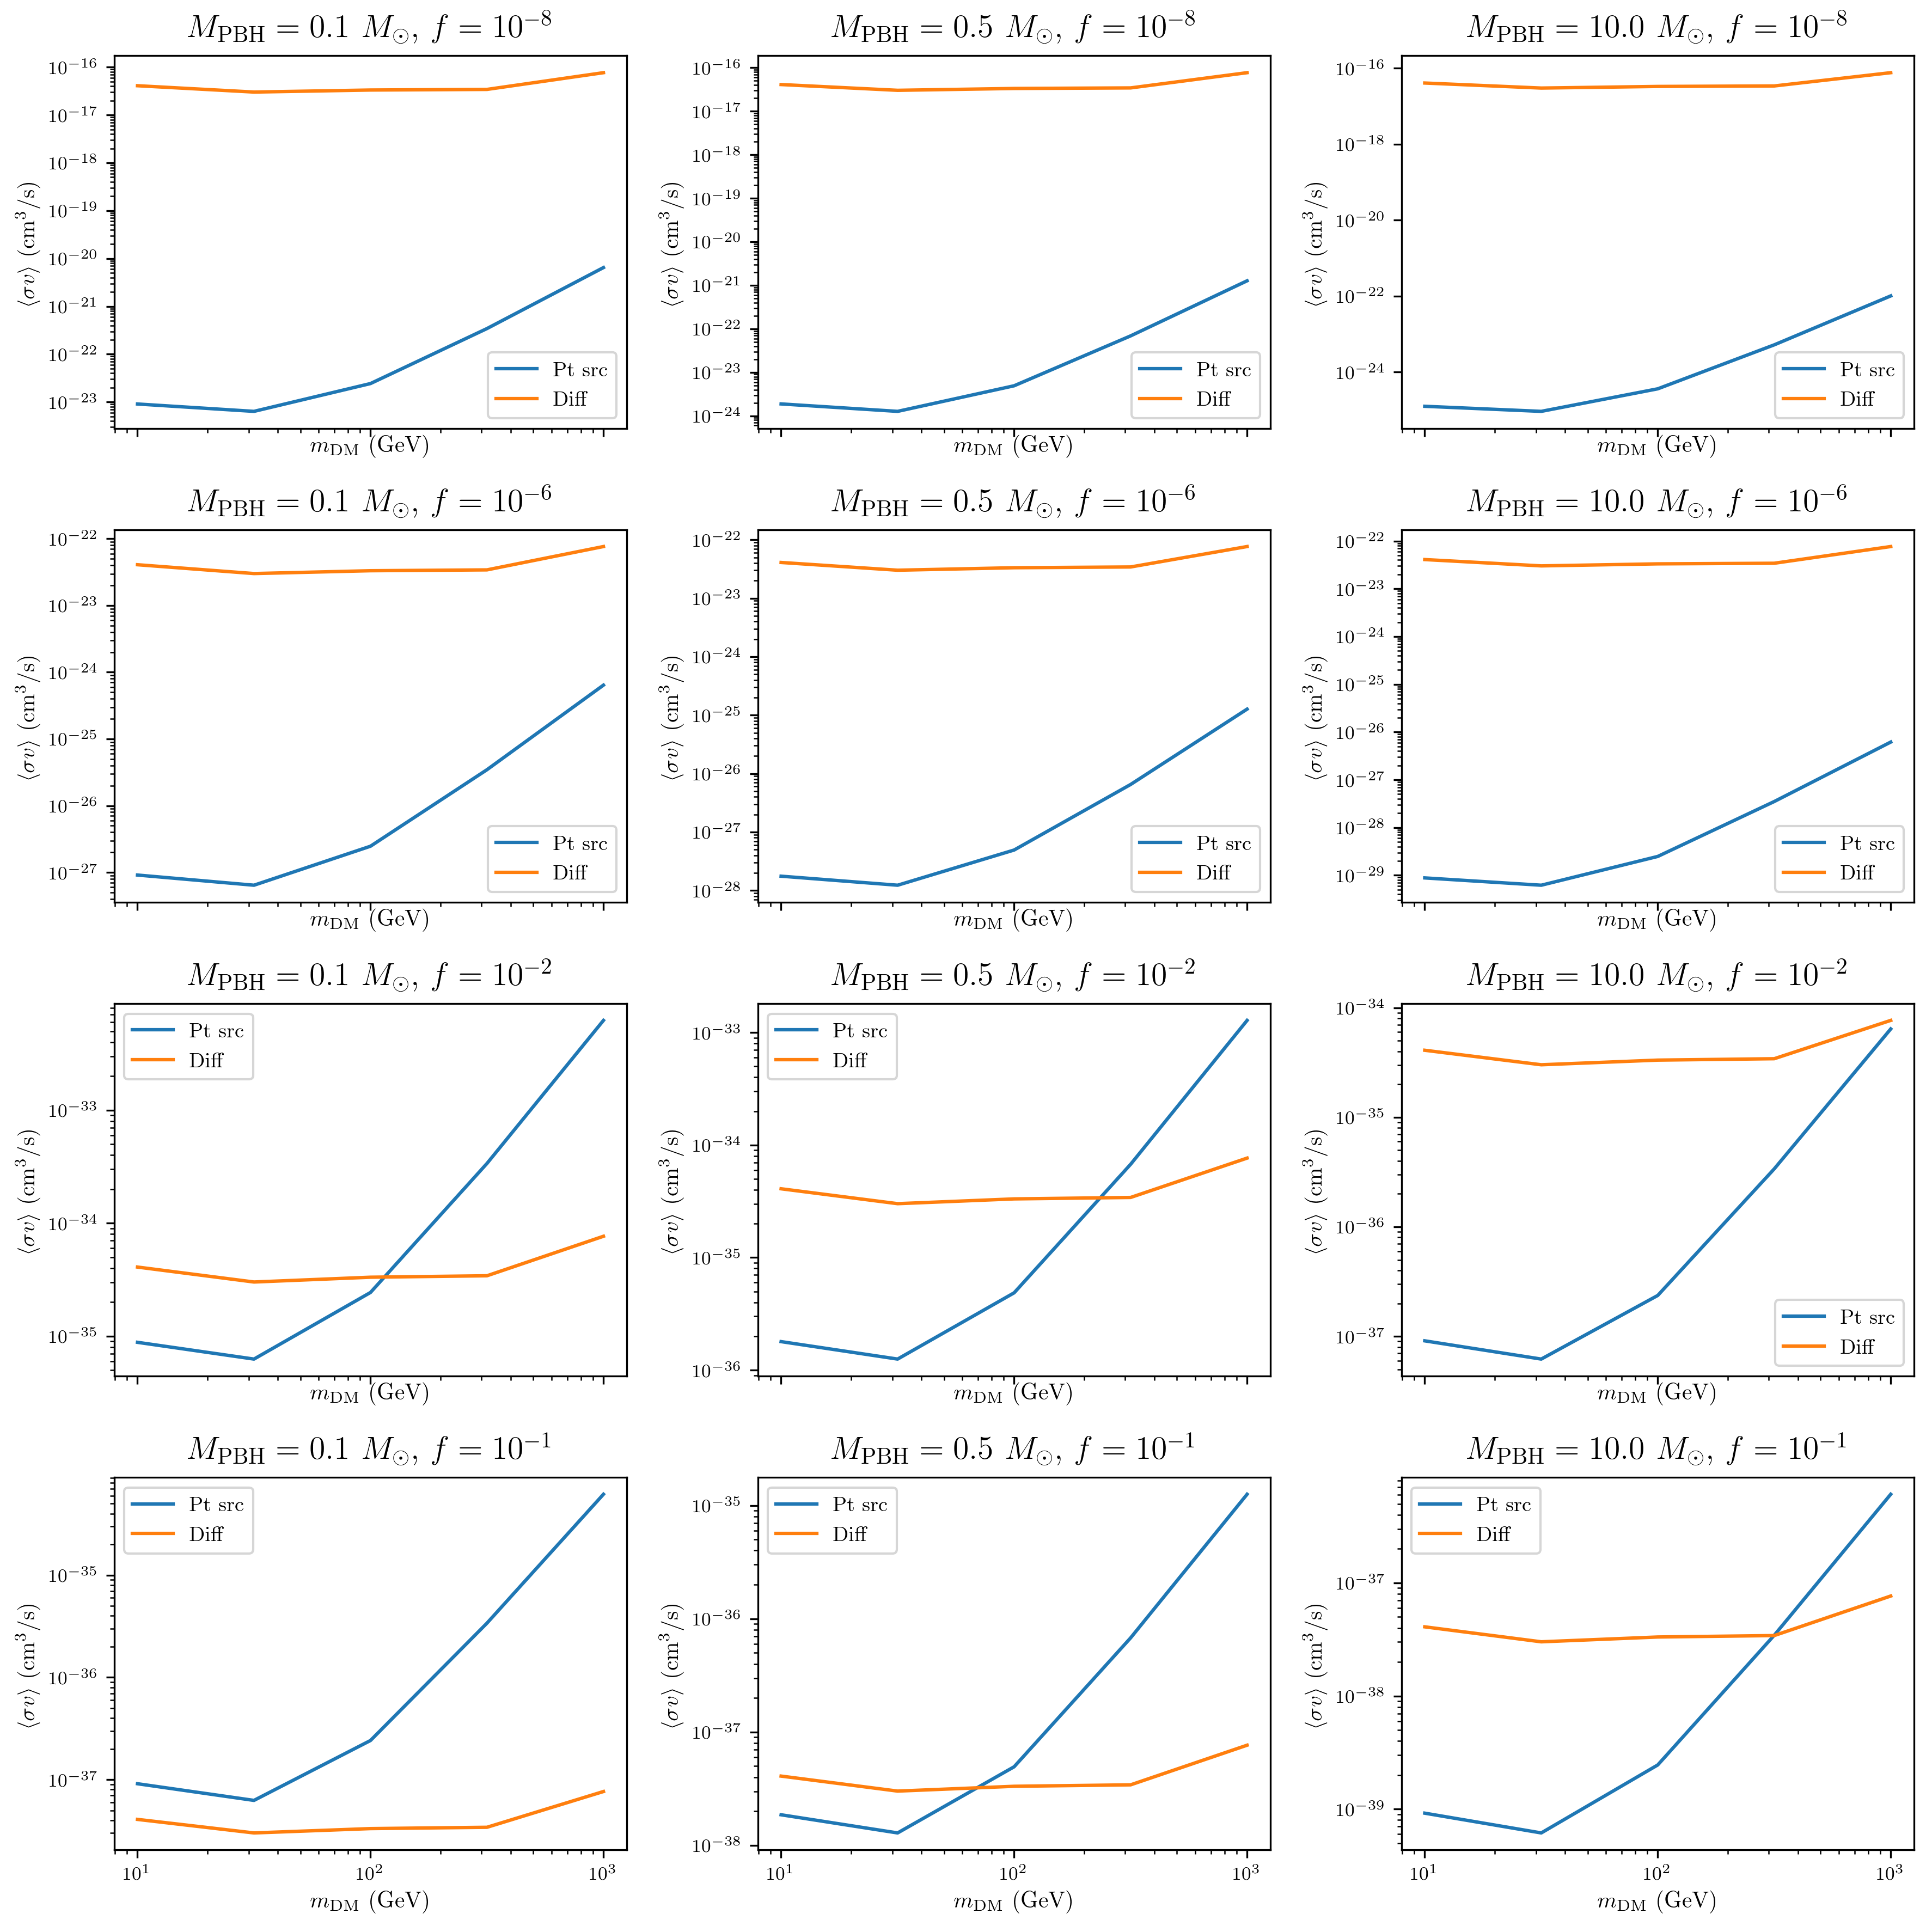

In [15]:
# PBH properties
m_pbhs = np.array([0.1, 0.5, 10.])
fs = np.array([1e-8, 1e-6, 1e-2, 1e-1])
m_dms = np.logspace(1, 3, 5)

fig, axes = plt.subplots(len(fs), len(m_pbhs), sharex=True,# sharey=True,
                         figsize=(12, 12))

for i, f in enumerate(fs):
    for j, m_pbh in enumerate(m_pbhs):
        ax = axes[i, j]
        # Compute bounds on <sigma v>
        svs_pt = sv_bound_pt(m_dms, m_pbh, f)
        svs_diff = sv_bound_diff(m_dms, m_pbh, f)
        
        ax.plot(m_dms, svs_pt, label="Pt src")
        ax.plot(m_dms, svs_diff, label="Diff")

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.legend()
        ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
        ax.set_ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
        ax.set_title(r"$M_{\mathrm{PBH}} = %.1f~M_\odot$, $f=10^{%i}$" %
                     (m_pbh, int(np.log10(f))))
        
fig.tight_layout()

**$\Phi_\gamma(>1~\mathrm{GeV})$ distribution with $\langle \sigma v \rangle$ set to the diffuse constraint.** This shows why the point-source constraint is so much weaker. Since $\langle \sigma v \rangle_{\mathrm{diff}}$ is low, the flux distribution is below Fermi's flux threshold. The point-source constraint is set by increasing $\langle \sigma v \rangle$ until 19 PBHs lie above the flux threshold. But this requires integrating over the tail of the flux distribution. Since the distribution is log-normal, increasing $\langle \sigma v \rangle$ a little has only a small effect on how many PBHs pass the threshold: $\langle \sigma v \rangle$ must be increased quite a bit before 19 do.

In [58]:
def fit_flux_dist(m_dm, sv, m_pbh):
    """Parameter estimates for mean and stdev for log-normal fit to the
    Phi(>1 GeV) distribution.
    """
    mu_log10_Phi = np.log10(10**(-13.3) * (sv / 3e-26)**(1/3) *
                        (m_dm / 100)**(-1/3) * (m_pbh / 1))
    sigma_log10_Phi = 1.21
    return mu_log10_Phi, sigma_log10_Phi

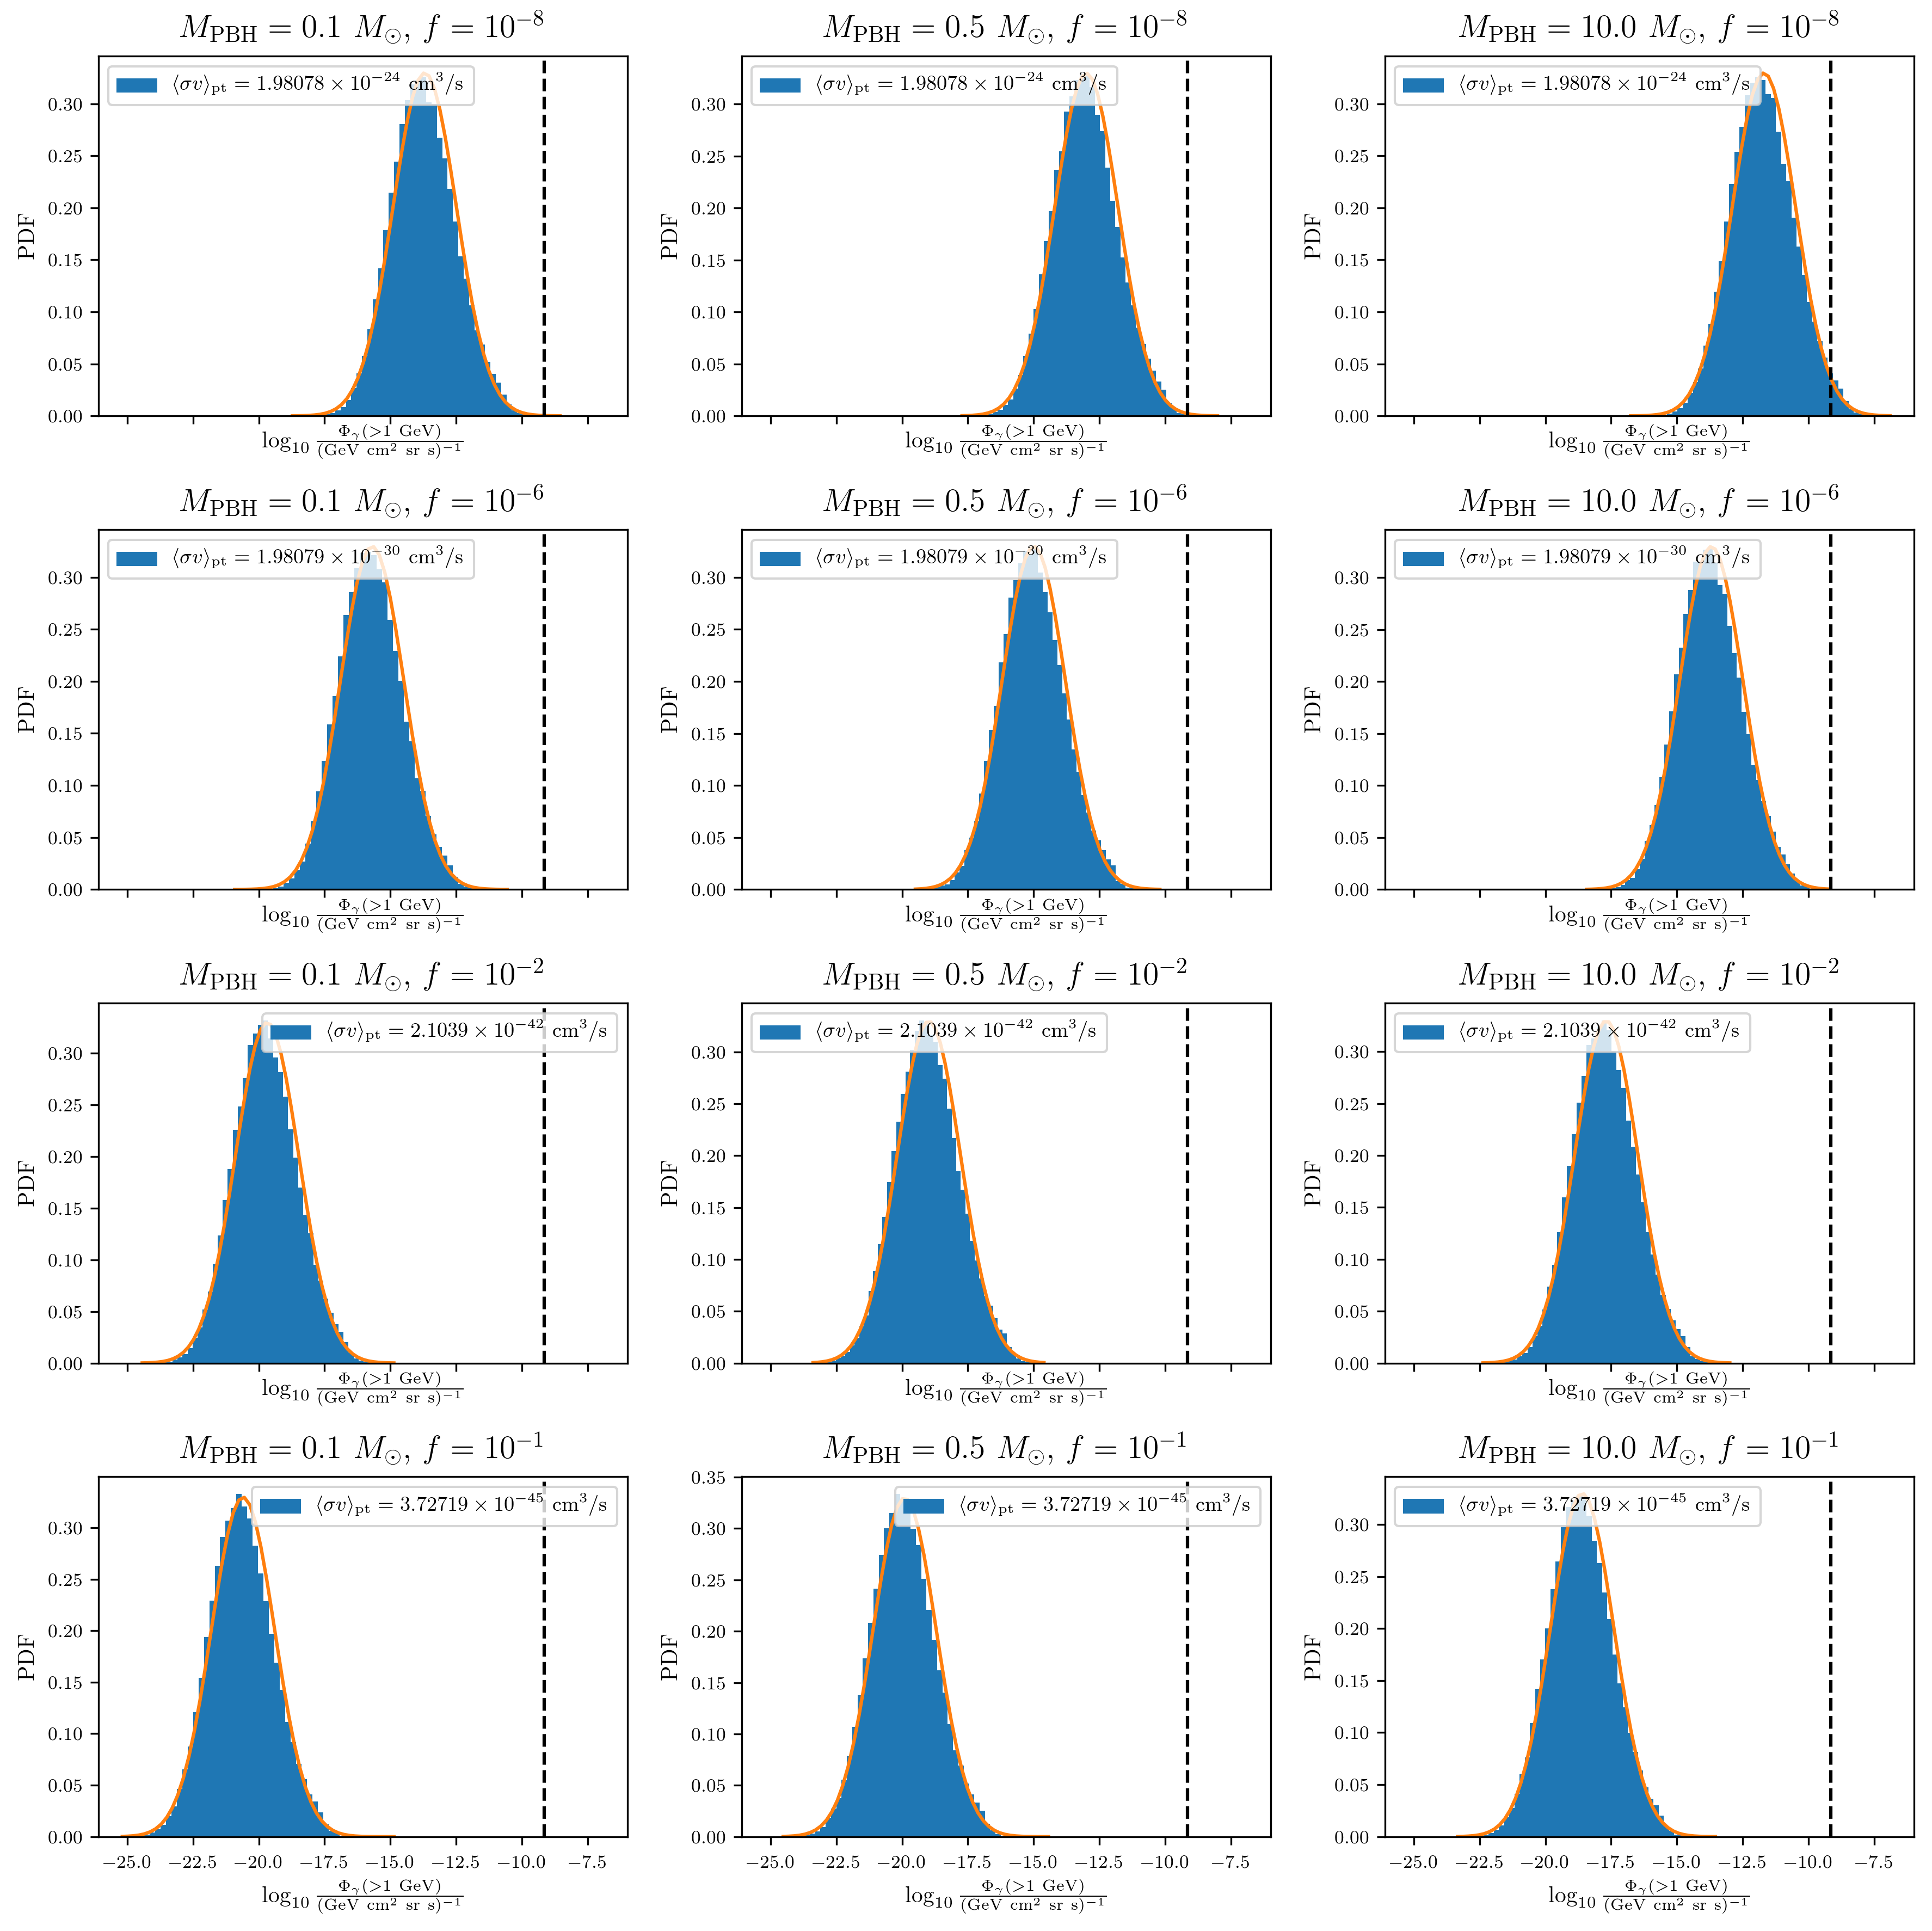

In [57]:
# PBH properties
m_pbhs = np.array([0.1, 0.5, 10.])
fs = np.array([1e-8, 1e-6, 1e-2, 1e-1])
m_dm = 100.

fig, axes = plt.subplots(len(fs), len(m_pbhs), sharex=True, figsize=(12, 12))

for i, f in enumerate(fs):
    for j, m_pbh in enumerate(m_pbhs):
        ax = axes[i, j]
        # Compute diffuse bound on <sigma v>
        sv_diff = sv_bound_diffuse(m_dm, m_pbh, f)
        
        # Histogram the PBH fluxes
        sim = PBHHaloSim(m_pbh, f, m_dm, sv_diff, n_samples=100000)
        sim.run(efficient_angular_sampling=False, truncate_radial_samples=False)
        ax.hist(np.log10(sim.fluxes), density=True,
                label=r"$\langle \sigma v \rangle_{\mathrm{pt}} = %s$ cm$^3$/s" %
                sci_fmt(sv_diff), bins=50)
        # Fit flux distribution
        log10_Phis = np.linspace(np.log10(sim.fluxes).min(),
                                 np.log10(sim.fluxes).max())
        ax.plot(log10_Phis,
                stats.norm(*fit_flux_dist(m_dm, sv_diff, m_pbh)).pdf(log10_Phis))
        
        # Fermi's pt-src flux threshold
        ax.axvline(np.log10(flux_thresh_0), color="k", linestyle='--')

        ax.legend()
        ax.set_xlabel(r"$\log_{10}\frac{\Phi_\gamma(>1~\mathrm{GeV})}"
                      r"{(\mathrm{GeV}~\mathrm{cm}^2~\mathrm{sr}~\mathrm{s})^{-1}}$")
        ax.set_ylabel("PDF")
        ax.set_title(r"$M_{\mathrm{PBH}} = %.1f~M_\odot$, $f=10^{%i}$" %
                     (m_pbh, int(np.log10(f))))

fig.tight_layout()

**Scaling of $N$ with $\langle \sigma v \rangle$.** While $N \propto f \langle \sigma v \rangle^{1/2}$, the diffuse flux $\phi_\gamma(E) \propto f \langle \sigma v \rangle^{1/3}$. This means the diffuse limit scales more strongly with the observed EGB and $f$ than the point-source limit scales with $N_U$ and $f$.

In [59]:
m_pbh = 0.5
f = 1e-2
m_dm = 100.

svs = np.logspace(-45, -25)
n_dets = []
pr_dets = []

for i, sv in enumerate(svs):
    sim = PBHHaloSim(m_pbh, f, m_dm, sv, n_samples=100000)
    sim.run(efficient_angular_sampling=True, truncate_radial_samples=True)
    n_dets.append(sim.n_det)
    pr_dets.append(sim.pr_det)

n_dets = np.array(n_dets)
pr_dets = np.array(pr_dets)

print("Delta(log10(n_det)) / Delta(log10(sv)) = {}".format(
    np.diff(np.log10(n_dets[[0, -1]])) / np.diff(np.log10(svs[[0, -1]]))))

Delta(log10(n_det)) / Delta(log10(sv)) = [0.49742046]


**Limit comparison:** diffuse fluxes for $\langle \sigma v \rangle$ set to the point-source and diffuse bounds.

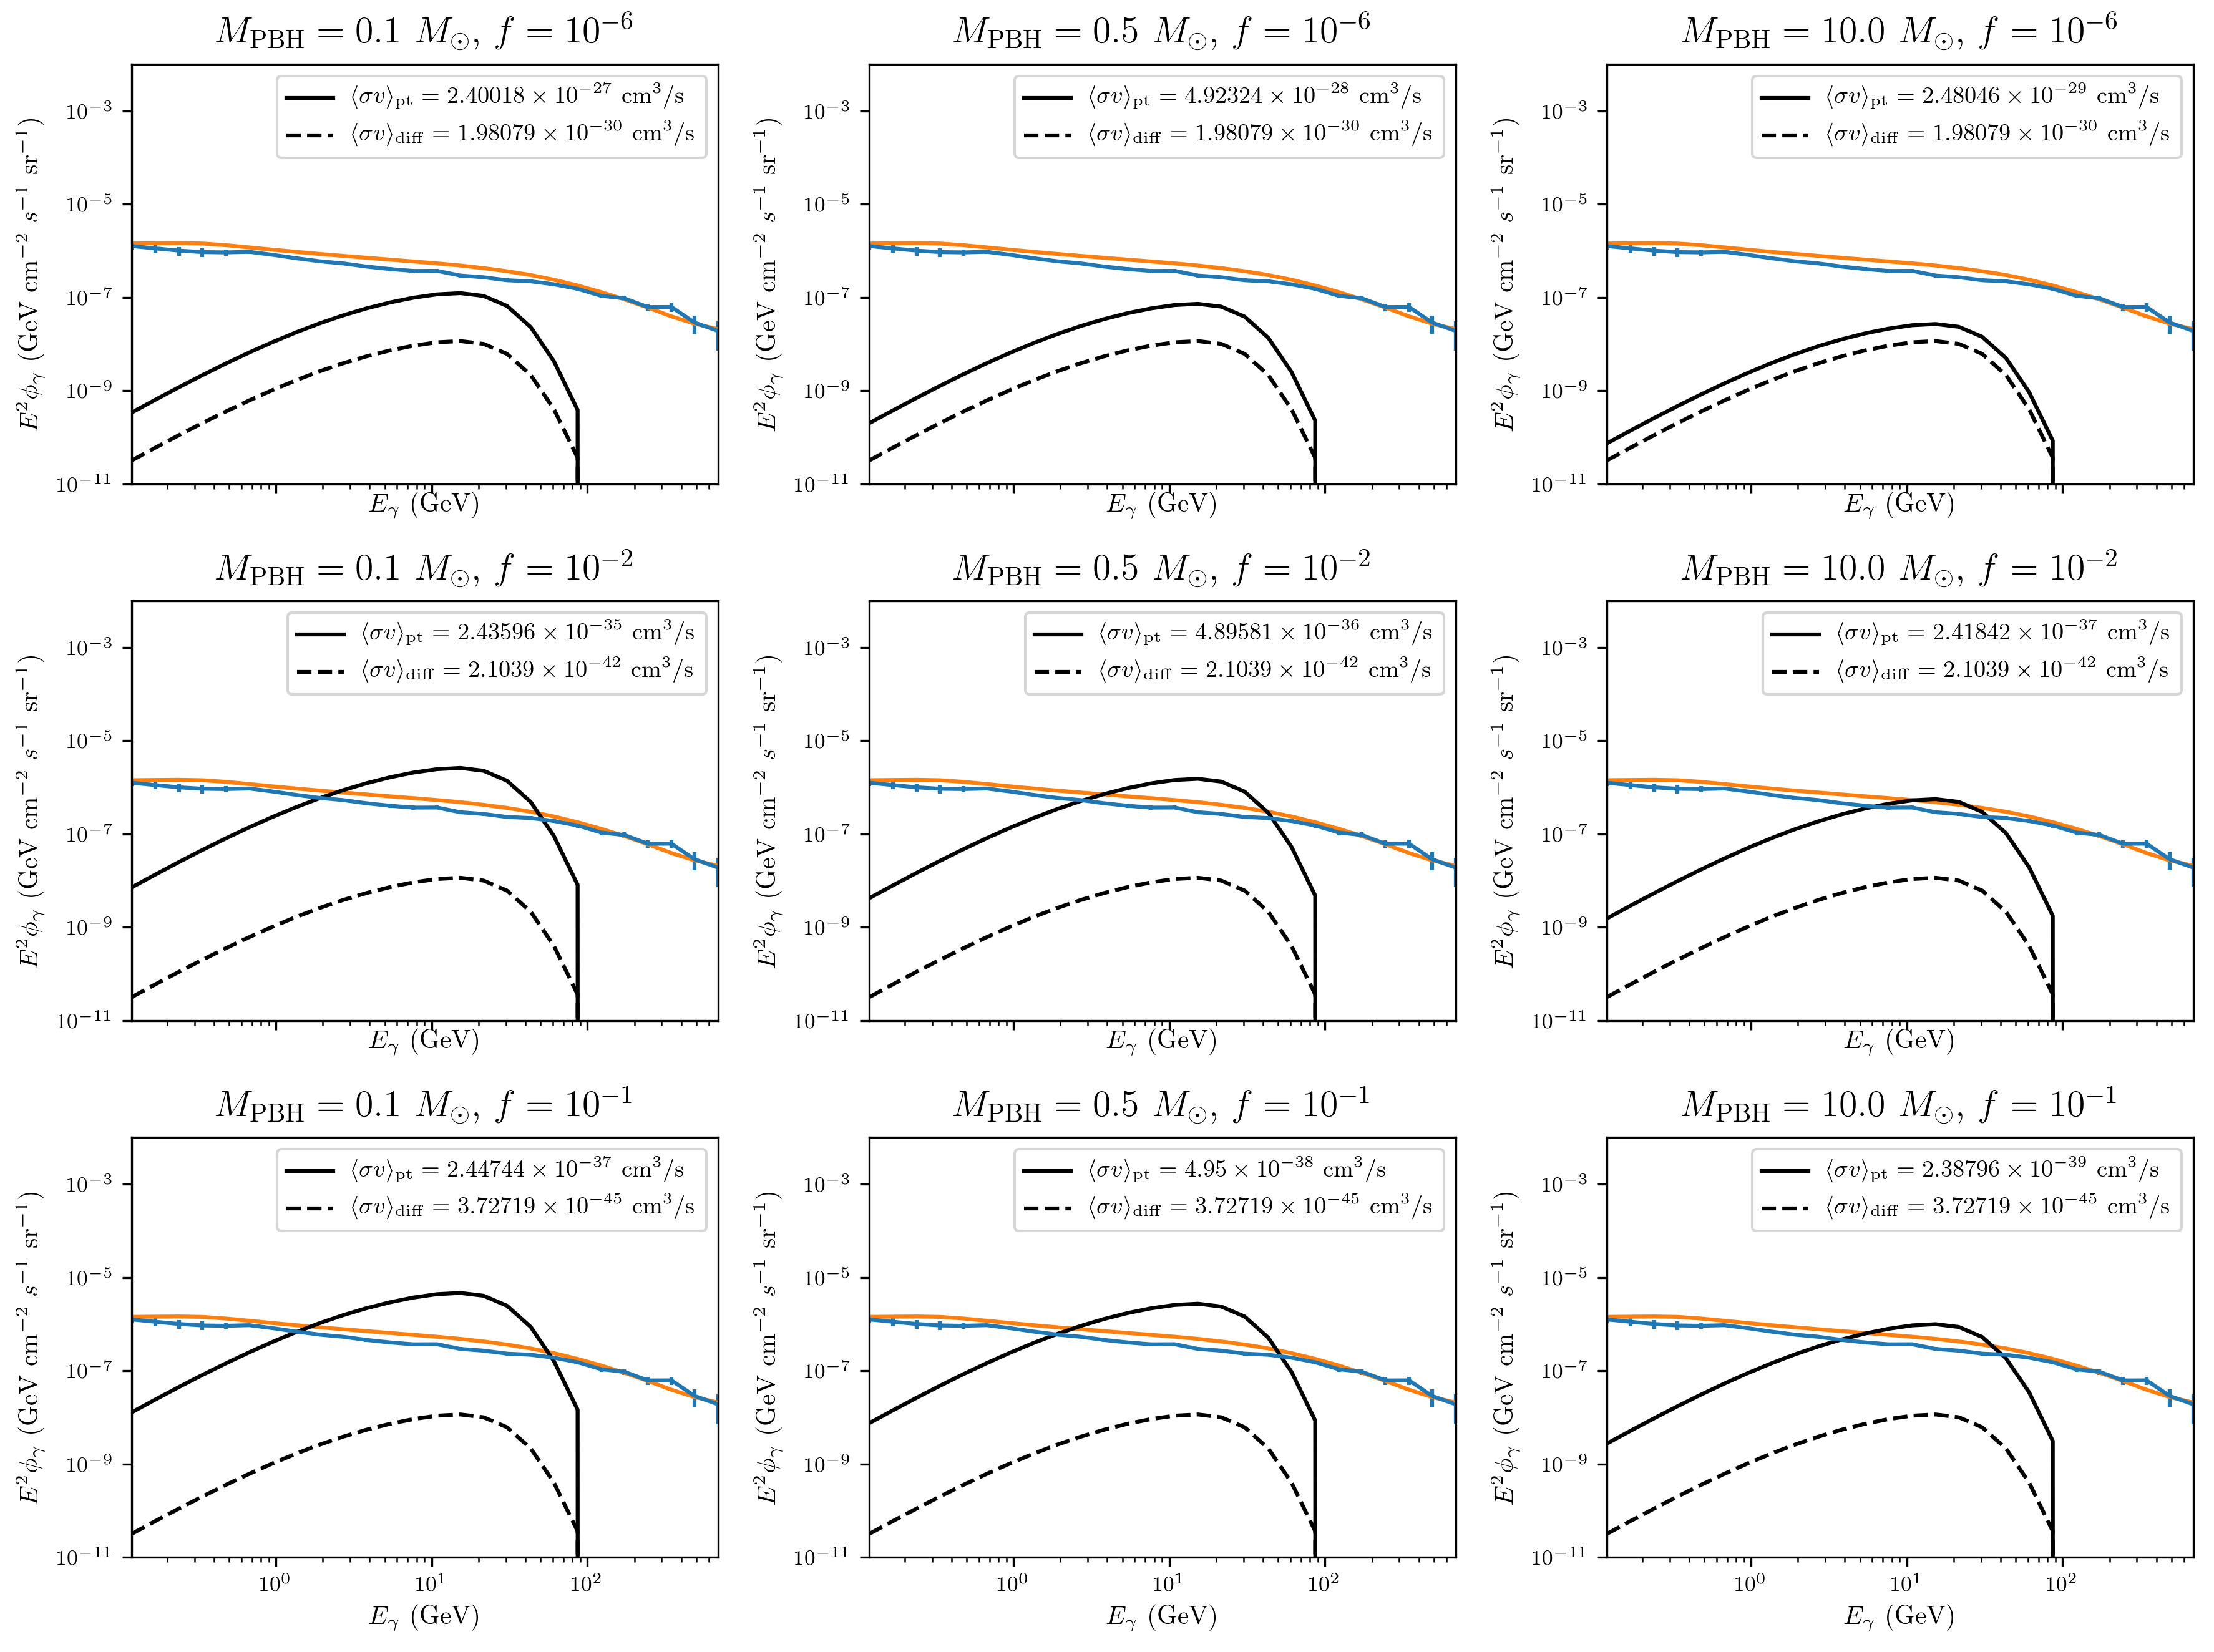

In [18]:
# PBH properties
m_pbhs = np.array([0.1, 0.5, 10.])
fs = np.array([1e-6, 1e-2, 1e-1])
m_dm = 100.

fig, axes = plt.subplots(len(fs), len(m_pbhs), sharex=True, figsize=(12, 9))

for i, f in enumerate(fs):
    for j, m_pbh in enumerate(m_pbhs):
        ax = axes[i, j]
        # Compute bounds on <sigma v>
        sv_pt = sv_bound_pt(m_dm, m_pbh, f)
        sv_diff = sv_bound_diffuse(m_dm, m_pbh, f)

        # Observed EGB
        ax.errorbar(e_egb, e_egb**2 * phi_egb,
                    e_egb**2 * np.stack([err_low_egb, err_high_egb]))

        # Background
        ax.plot(e_egb, e_egb**2 * phi_egb_bg(e_egb))

        # PBH diffuse fluxes
        ax.plot(e_egb, e_egb**2 * phi_diff(e_egb, m_dm, sv_pt, m_pbh, f), 'k',
                label=r"$\langle \sigma v \rangle_{\mathrm{pt}} = %s$ cm$^3$/s" %
                sci_fmt(sv_pt))
        ax.plot(e_egb, e_egb**2 * phi_diff(e_egb, m_dm, sv_diff, m_pbh, f), '--k',
                label=r"$\langle \sigma v \rangle_{\mathrm{diff}} = %s$ cm$^3$/s" %
                sci_fmt(sv_diff))

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim(e_egb[[0, -1]])
        ax.set_ylim(1e-11, 1e-2)
        ax.legend()
        ax.set_xlabel(r"$E_\gamma$ (GeV)")
        ax.set_ylabel(r"$E^2 \phi_\gamma$ (GeV cm$^{-2}$ $s^{-1}$ sr$^{-1}$)")
        ax.set_title(r"$M_{\mathrm{PBH}} = %.1f~M_\odot$, $f=10^{%i}$" %
                     (m_pbh, int(np.log10(f))))
        
fig.tight_layout()

## Trying to analytically approximate the number of detectable PBHs. Turns out the log-normal doesn't fit the tails of the flux distribution very well...

In [53]:
def n_det_approx(m_dm, sv, m_pbh, f):
    mu_log10_Phi, sigma_log10_Phi = fit_flux_dist(m_dm, sv, m_pbh)
    n_pbh = f * m_mw_dm / m_pbh
    return erfc((np.log10(flux_thresh_0) - mu_log10_Phi) / sigma_log10_Phi)

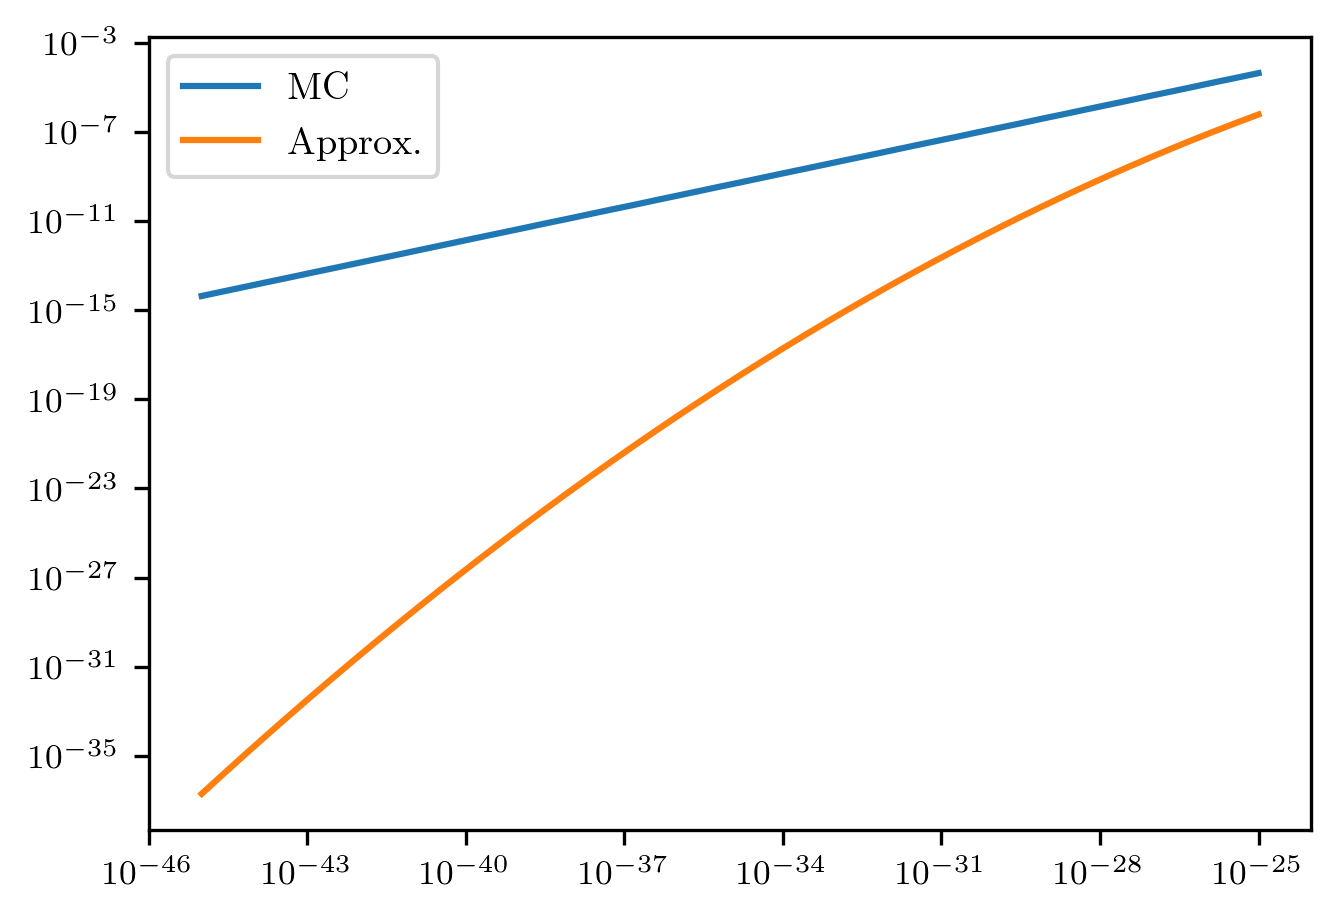

In [49]:
# plt.xlim(1e-44, 1e-41)
# plt.ylim(1e-2, 5e-1)
plt.loglog(svs, pr_dets, label="MC")
plt.loglog(svs, n_det_approx(m_dm, svs, m_pbh, f), label="Approx.")
plt.legend()

<log10(Phi)>, var(log10(Phi)) = -16.837303038291445, 1.2148952771703574
# det = 0.0 +/- 0.0


Text(0, 0.5, 'PDF')

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


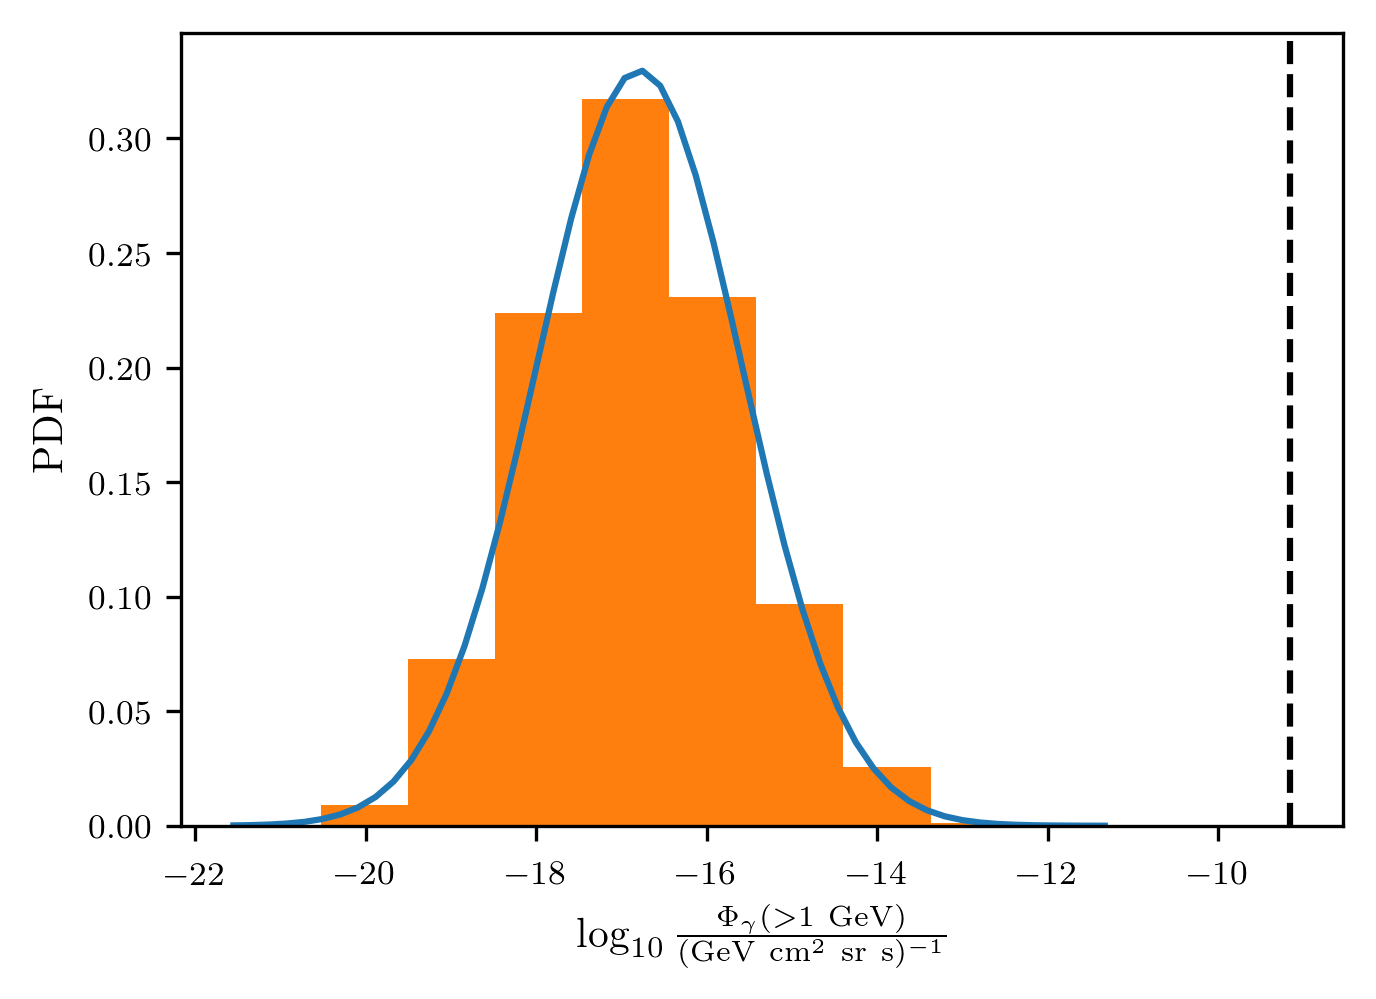

In [10]:
m_pbh = 10.
f = 3e-5
m_dm = 100.
sv = sv_bound_pt(m_dm, m_pbh, f)
sim = PBHHaloSim(m_pbh, f, m_dm, sv, n_samples=100000)
sim.run(efficient_angular_sampling=False, truncate_radial_samples=False)
print("<log10(Phi)>, var(log10(Phi)) = {}, {}".format(
            np.mean(np.log10(sim.fluxes)), np.std(np.log10(sim.fluxes))))
print("# det = {} +/- {}".format(sim.n_det, sim.n_det_err))

log10_Phis = np.linspace(np.log10(sim.fluxes).min(), np.log10(sim.fluxes).max())
# Log-normal fit
mu_log10_Phi = np.log10(10**(-13.3) * (sv / 3e-26)**(1/3) *
                        (m_dm / 100)**(-1/3) * (m_pbh / 1))
sigma_log10_Phi = 1.21
plt.plot(log10_Phis, stats.norm(mu_log10_Phi, sigma_log10_Phi).pdf(log10_Phis))

plt.axvline(np.log10(flux_thresh_0), color="k", linestyle='--')
plt.hist(np.log10(sim.fluxes), density=True);

plt.xlabel(r"$\log_{10}\frac{\Phi_\gamma(>1~\mathrm{GeV})}{(\mathrm{GeV}~\mathrm{cm}^2~\mathrm{sr}~\mathrm{s})^{-1}}$")
plt.ylabel("PDF")

# plt.yscale("log")

In [214]:
sim = PBHHaloSim(10., 1e-9, m_dm, 4e-19, n_samples=100000)
sim.run()
print("# det PBHs = {} +/- {}".format(sim.n_det, sim.n_det_err))

# det PBHs = 19.031458497976352 +/- 0.11994723029005455


In [215]:
sim.run(efficient_angular_sampling=False, truncate_radial_samples=False)
np.mean(np.log10(sim.fluxes)), np.std(np.log10(sim.fluxes))

(-10.770654279579318, 1.2064646004792234)

In [34]:
svs = np.logspace(-45, -25)
n_dets = []

for i, sv in enumerate(svs):
    sim = PBHHaloSim(m_pbh, f_map, m_dm, sv, n_samples=100000)
    sim.run(efficient_angular_sampling=False, truncate_radial_samples=False)
    if i == 0 or i == len(svs) - 1:
        print("<log10(Phi)>, var(log10(Phi) = {}, {}".format(
            np.mean(np.log10(sim.fluxes)), np.std(np.log10(sim.fluxes))))
    n_dets.append(sim.n_det)

n_dets = np.array(n_dets)

<log10(Phi)>, var(log10(Phi) = -20.937492336676716, 1.21495315096607
<log10(Phi)>, var(log10(Phi) = -14.268559738043834, 1.2081487021127173


## Scratch

Flux from a single PBH 1 kpc away

In [82]:
from pbhhalosim import PBHHaloSim

In [83]:
sim = PBHHaloSim(m_pbh, f_map, m_dm, sv*1e-3, n_samples=2000000)
sim.run(efficient_angular_sampling=False, truncate_radial_samples=False)
sim._max_detectable_distances();

In [92]:
pyramid_size = 2.3
pos_cut = ((np.abs(sim.positions[1]) < pyramid_size) &
           (np.abs(sim.positions[2]) < pyramid_size))
DeltaOmega = 4*np.sin(pyramid_size*np.pi/180)*pyramid_size*np.pi/180

np.sum(pos_cut), np.mean(sim.fluxes[pos_cut]) * np.sum(pos_cut) / sim.n_samples * sim.n_halo_pbhs / DeltaOmega

(931, 4.613769613529026e-07)

In [88]:
quad(phi_g_egb_fermi, 1., m_dm)[0]

5.471893305756905e-07

In [93]:
sim = PBHHaloSim(m_pbh, f_map, m_dm, sv, n_samples=2000000)
sim.run()
sim.n_det

41.716636506152746

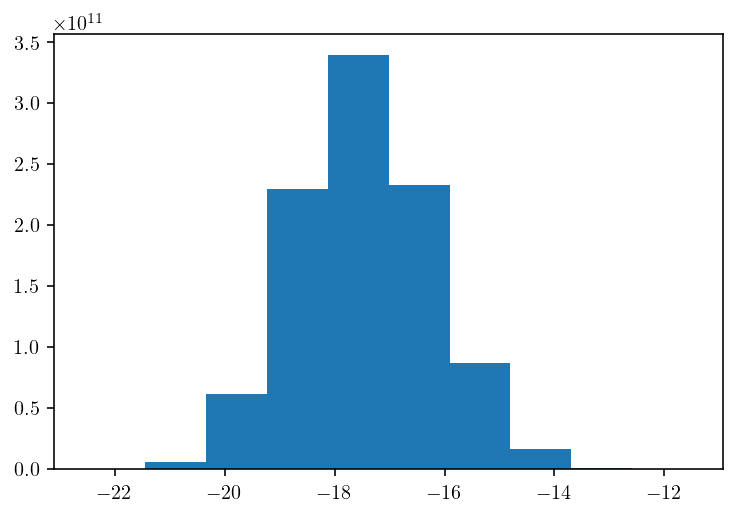

In [42]:
plt.hist(np.log10(sim.fluxes), weights=len(sim.fluxes) * [sim.n_halo_pbhs / sim.n_samples]);

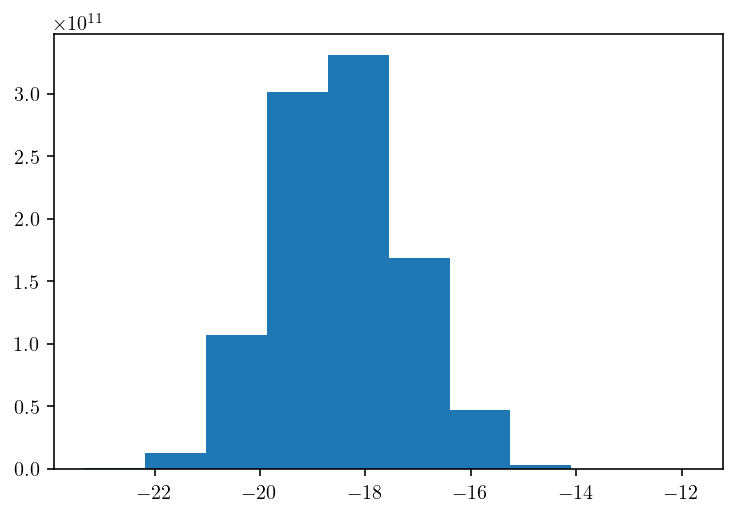

In [56]:
plt.hist(np.log10(sim.fluxes), weights=len(sim.fluxes) * [sim.n_halo_pbhs / sim.n_samples]);

In [57]:
7e-10 / (4*np.pi*np.sin(0.15*np.pi/180)**2)

8.12740524526842e-06

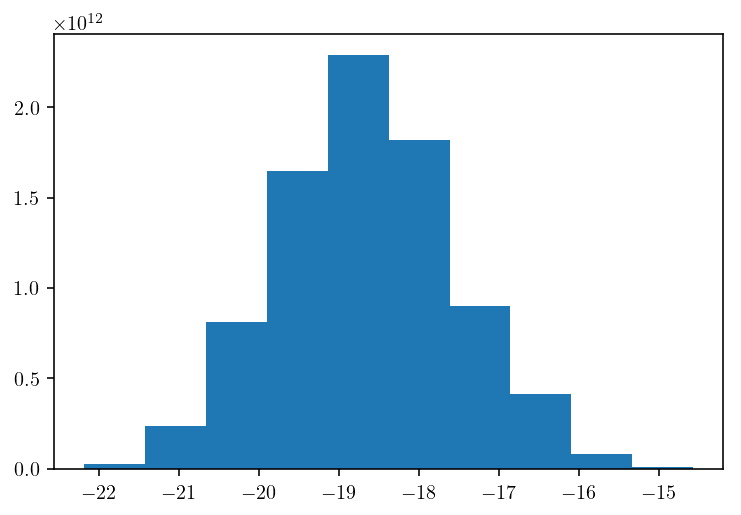

In [38]:
plt.hist(np.log10(sim.fluxes[pos_cut]),
         weights=np.sum(pos_cut) * [sim.n_halo_pbhs*np.sum(pos_cut) / sim.n_samples]);

In [15]:
def phi_pt(m_dm, sv, m_pbh, dist):
    return Gamma_pbh(m_dm, sv, m_pbh) * int_dnde_interps["b"](m_dm) / (4*np.pi * (kpc_to_cm*dist)**2)

This plot shows the flux above 1 GeV (galactic diffuse or from a single UCMH) divided by the relevant point of comparison (EGB or point-source threshold). It's clear that the average PBH is extremely unlikely to be close enough to Earth to be detectable as a point source. However, the galactic diffuse flux is very large since there are $\mathcal{O}(10^{12})$ PBHs in the Milky Way.

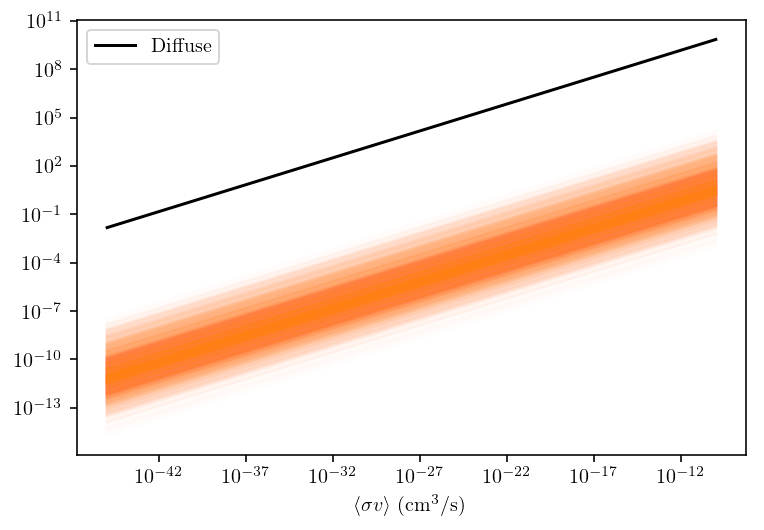

In [18]:
svs = np.logspace(-45, -10)

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")

for dist in sim.positions[0][::1000]:
    plt.plot(svs, phi_pt(m_dm, svs, m_pbh, dist) / flux_thresh_0, color=colors[1], alpha=0.01)

plt.plot(svs, dphi_dOmega_gal(m_dm, svs, m_pbh, f_map) / quad(phi_g_egb_fermi, 1., 100.)[0],
         'k', label="Diffuse")

plt.legend()

# GAMBIT contours

In [8]:
def plot_gambit_contour(gambit_model, ax, color=None, linewidth=None, padding=10, level=6):
    # TODO: Christoph said 3, not 6!!!
    gambit_contour = np.load("{}contours_{}.npy".format(gambit_dir, gambit_model)).T
    m_dm_g = np.logspace(1, 4, gambit_contour.shape[1])[padding:]
    sv_g = np.logspace(-35, -23, gambit_contour.shape[0])[padding:]
    m_dm_g_mg, sv_g_mg = np.meshgrid(m_dm_g, sv_g)
    gambit_contour = gambit_contour[padding:, padding:]
    
    ax.contour(m_dm_g_mg, sv_g_mg, gambit_contour, levels=[level],
               colors=[color], linewidth=linewidth)

# MC errors in $p_\gamma$

In [5]:
# Load table
svs, m_dms, p_gamma, p_gamma_err = load_p_gamma(m_pbh)
sv_mg, m_dm_mg = np.meshgrid(svs, m_dms)

/Users/acoogan/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/acoogan/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/acoogan/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


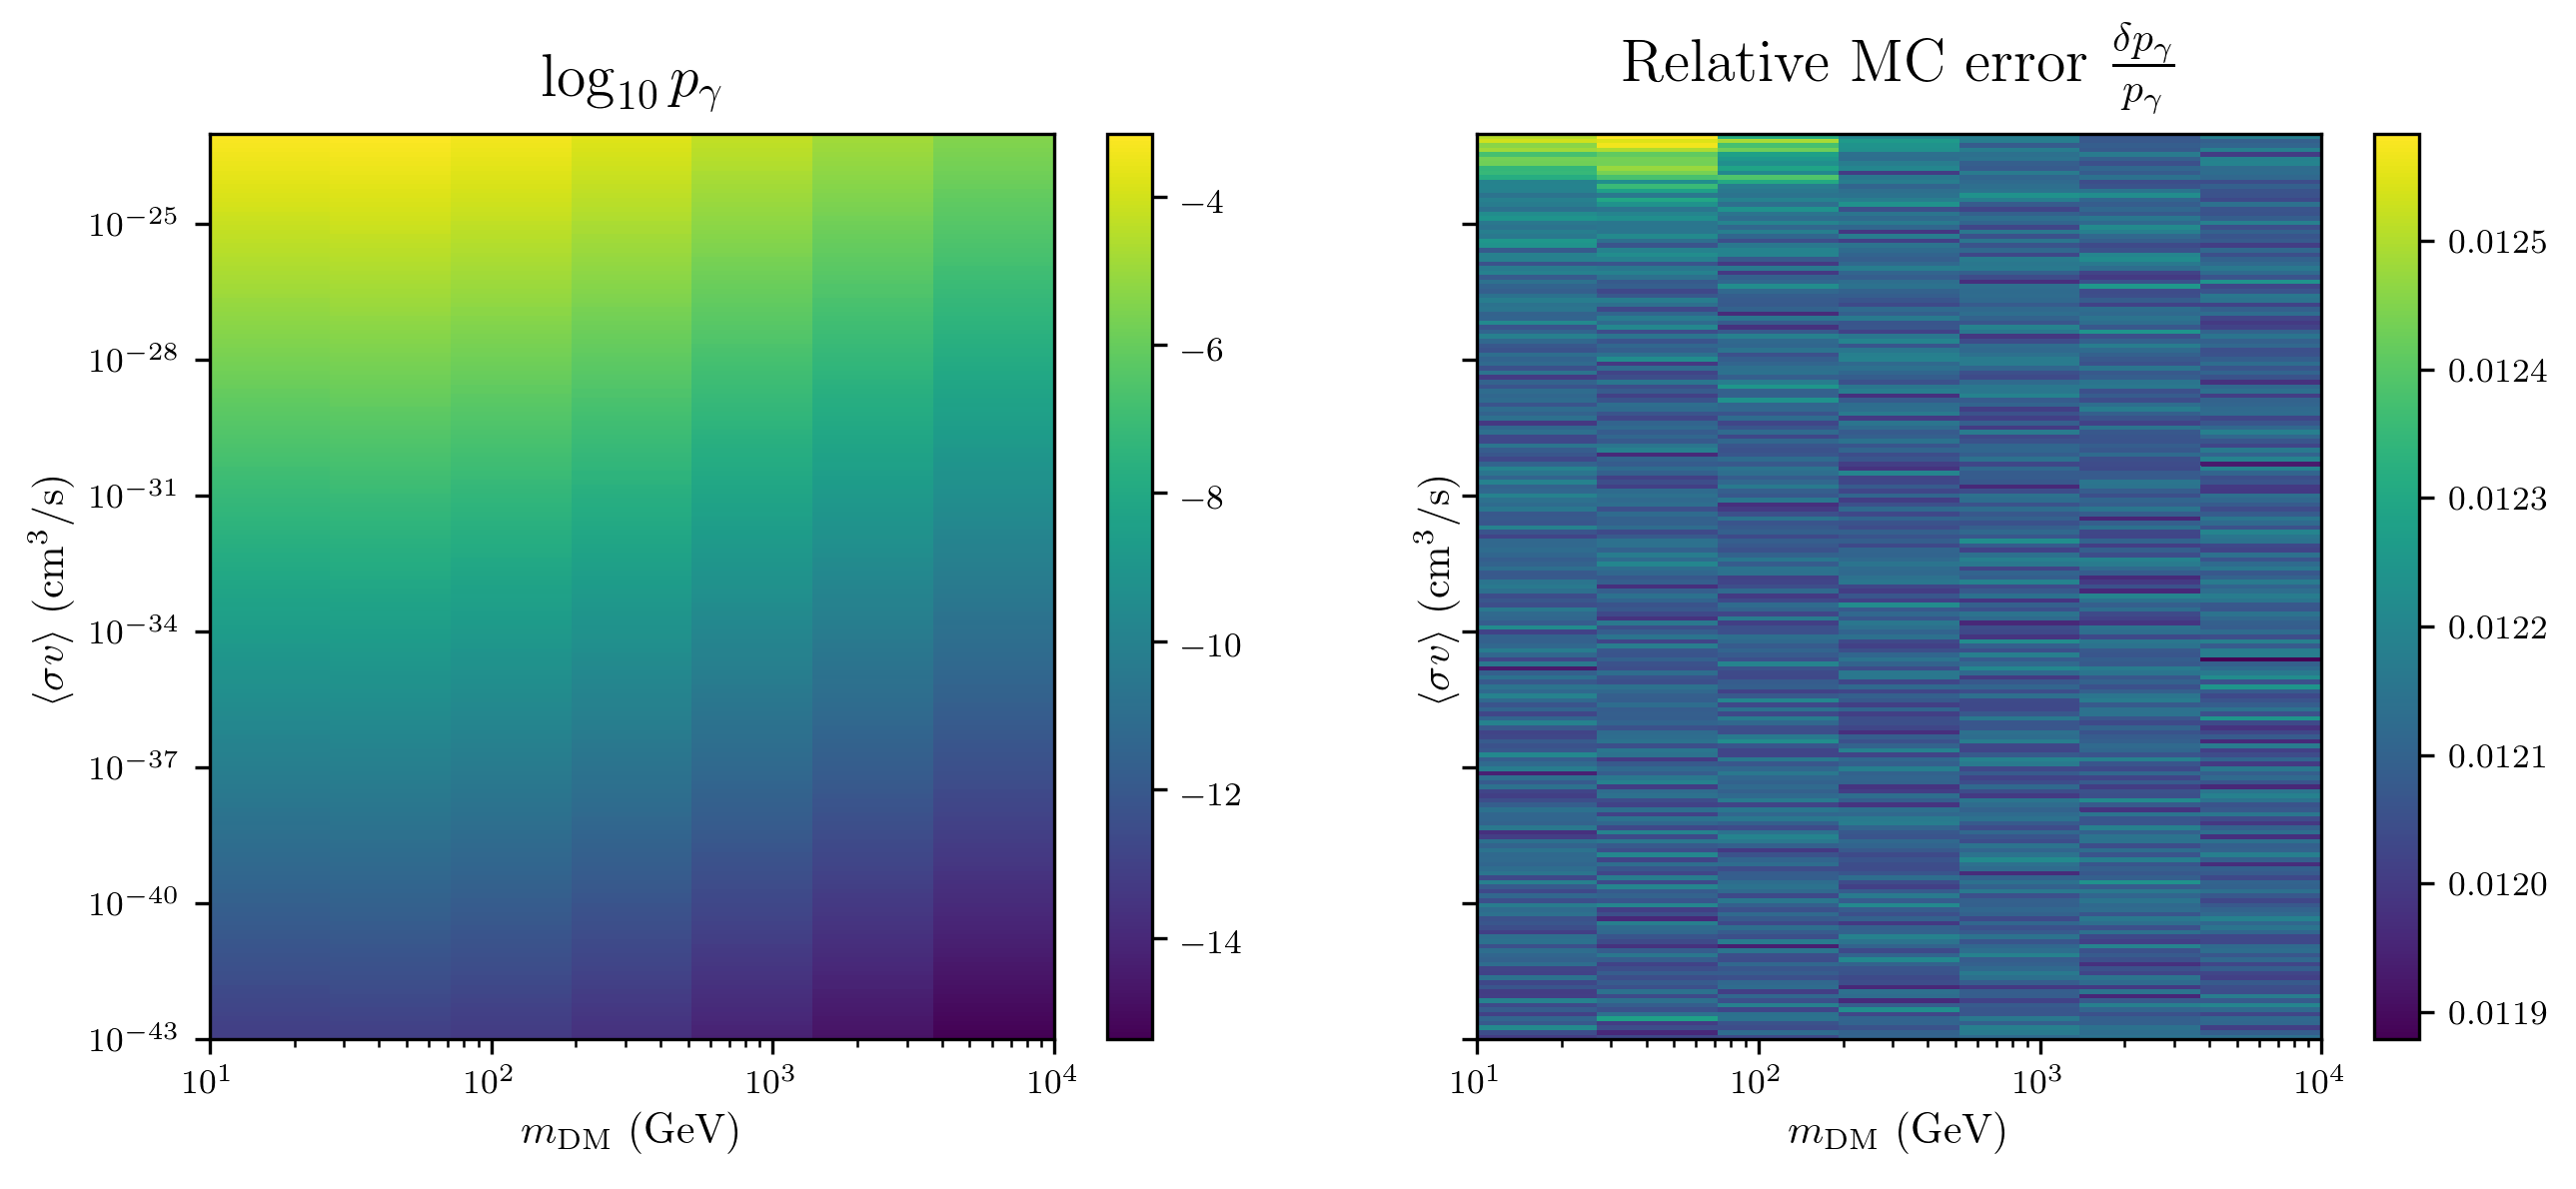

In [6]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))

for ax in axes.flatten():
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
    ax.set_ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")

ax = axes[0]
ax.set_title(r"$\log_{10} p_\gamma$")
img_vals = ax.pcolormesh(m_dm_mg, sv_mg, np.log10(p_gamma(sv_mg, m_dm_mg)))
plt.colorbar(img_vals, ax=ax)

ax = axes[1]
ax.set_title(r"Relative MC error $\frac{\delta p_\gamma}{p_\gamma}$")
img_rel_errs = ax.pcolormesh(
    m_dm_mg, sv_mg, (p_gamma_err(sv_mg, m_dm_mg) / p_gamma(sv_mg, m_dm_mg)))
plt.colorbar(img_rel_errs, ax=ax)

# PDFs and CDFs

/Users/acoogan/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


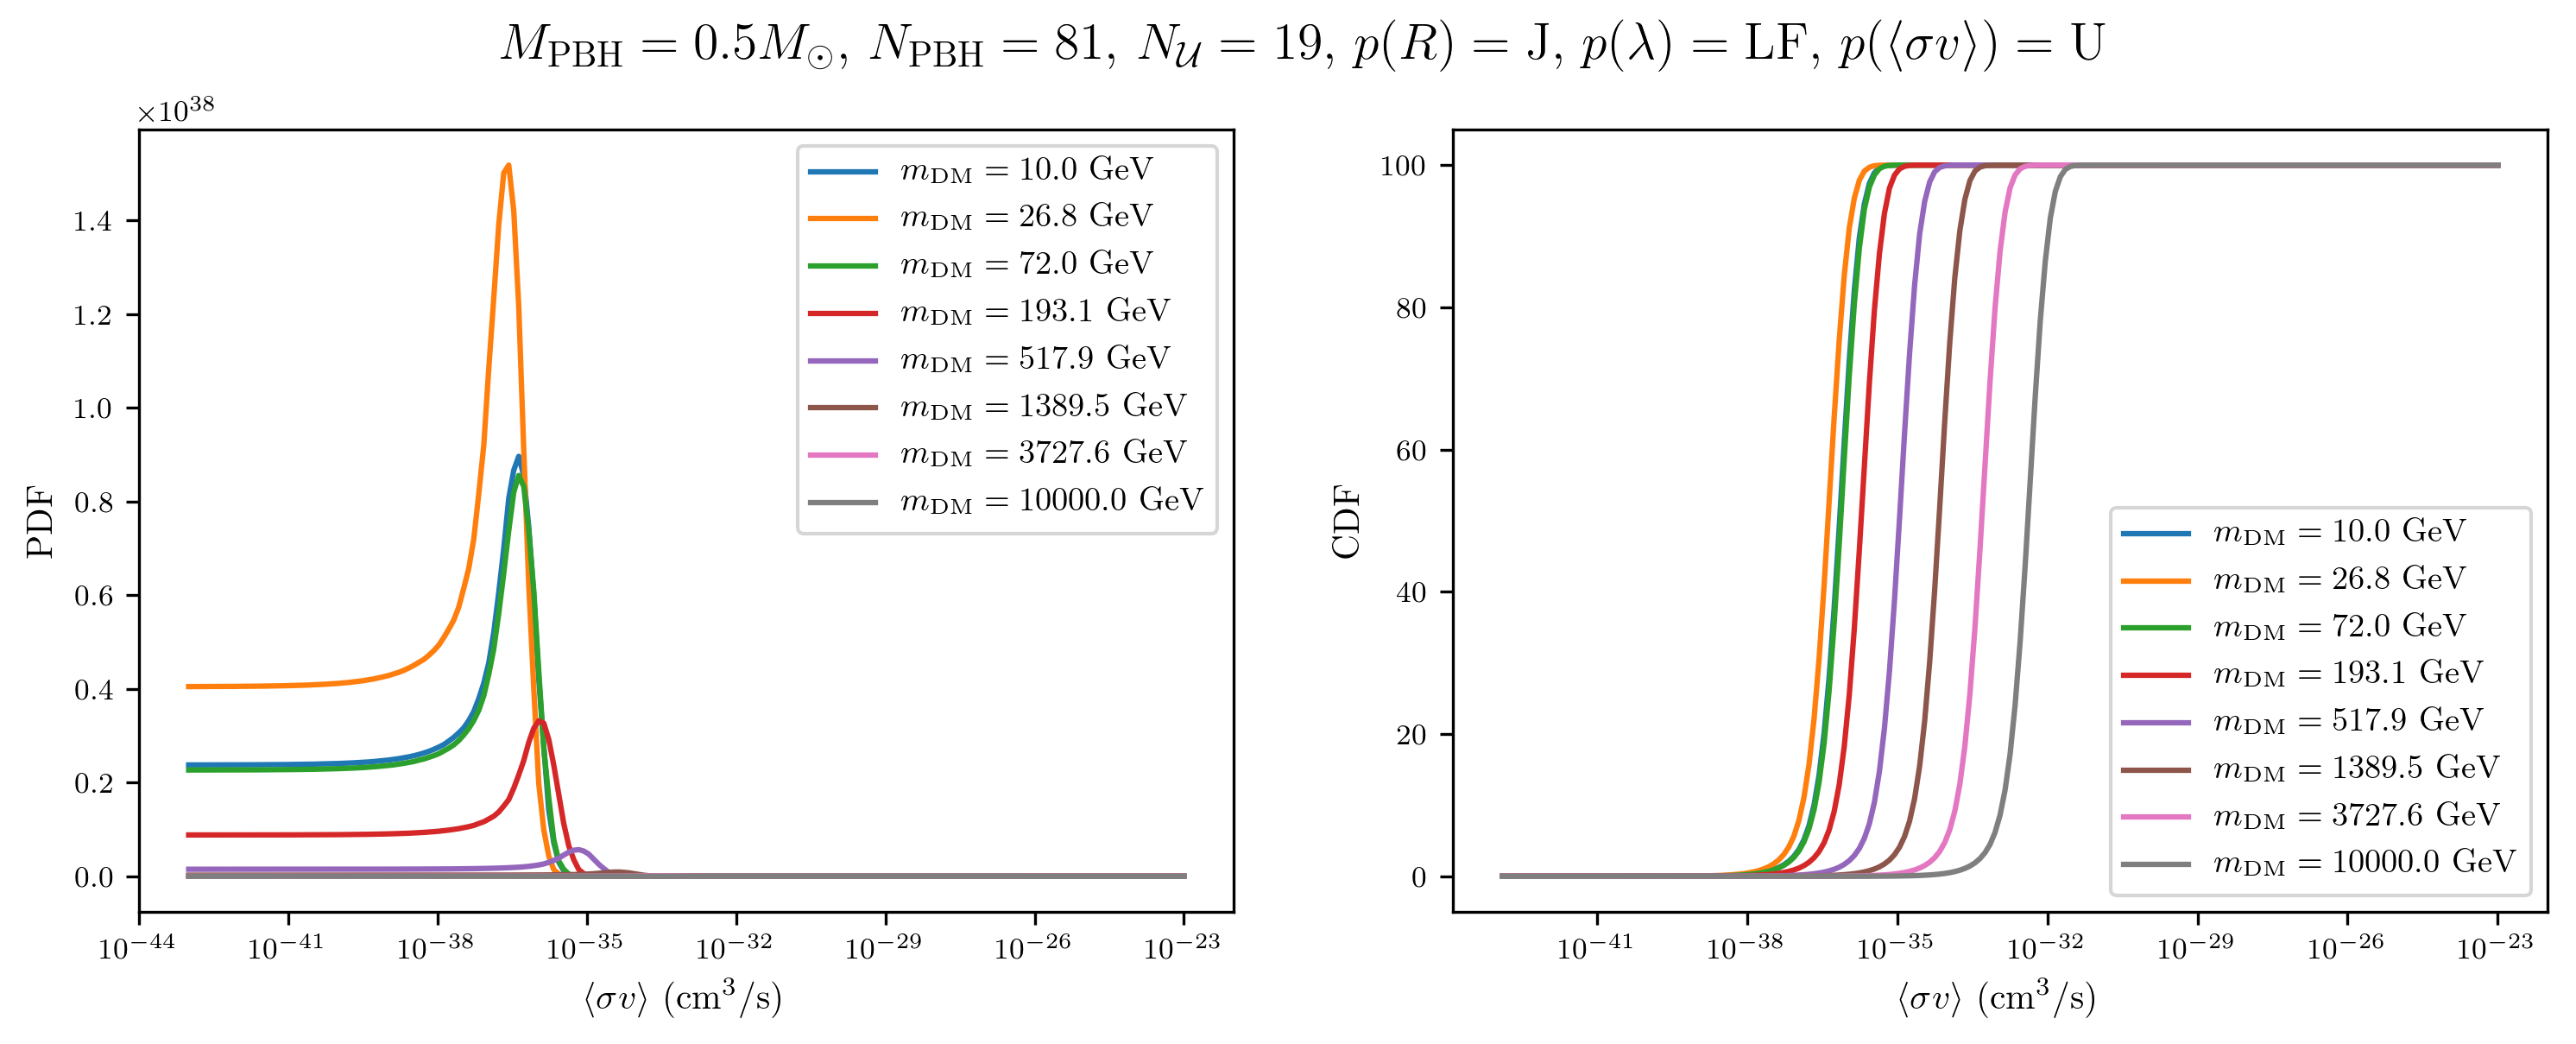

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
for i, m_dm in enumerate(m_dms):
    ax.plot(svs, post_vals[:, i], label=r"$m_{\mathrm{DM}} = %.1f$ GeV" % m_dm)
ax.set_xscale("log")
ax.set_xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
ax.set_ylabel("PDF")
ax.legend()

ax = axes[1]
for i, m_dm in enumerate(m_dms):
    ax.plot(svs[1:], cumtrapz(post_vals[:, i], svs), label=r"$m_{\mathrm{DM}} = %.1f$ GeV" % m_dm)
ax.set_xscale("log")
ax.set_xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
ax.set_ylabel("CDF")
ax.legend()

fig.suptitle((r"$M_{\mathrm{PBH}}=%.1f M_\odot$, "
              r"$N_{\mathrm{PBH}}=%i$, "
              r"$N_{\mathcal{U}}=%i$, "
              r"$p(R)=\mathrm{%s}$, $p(\lambda)=\mathrm{%s}$, $p(\langle \sigma v \rangle)=\mathrm{%s}$") %
             (m_pbh, n_pbh, n_u_0, merger_rate_prior, lambda_prior, sv_prior))

fig.savefig(
    "figures/sv_bounds/monitoring_M={:.1f}_N={}_prior_rate={}_prior_lambda={}_prior_sv={}.pdf".format(
    m_pbh, n_pbh, merger_rate_prior, lambda_prior, sv_prior))

# Bounds

In [14]:
m_dms.shape

(10,)

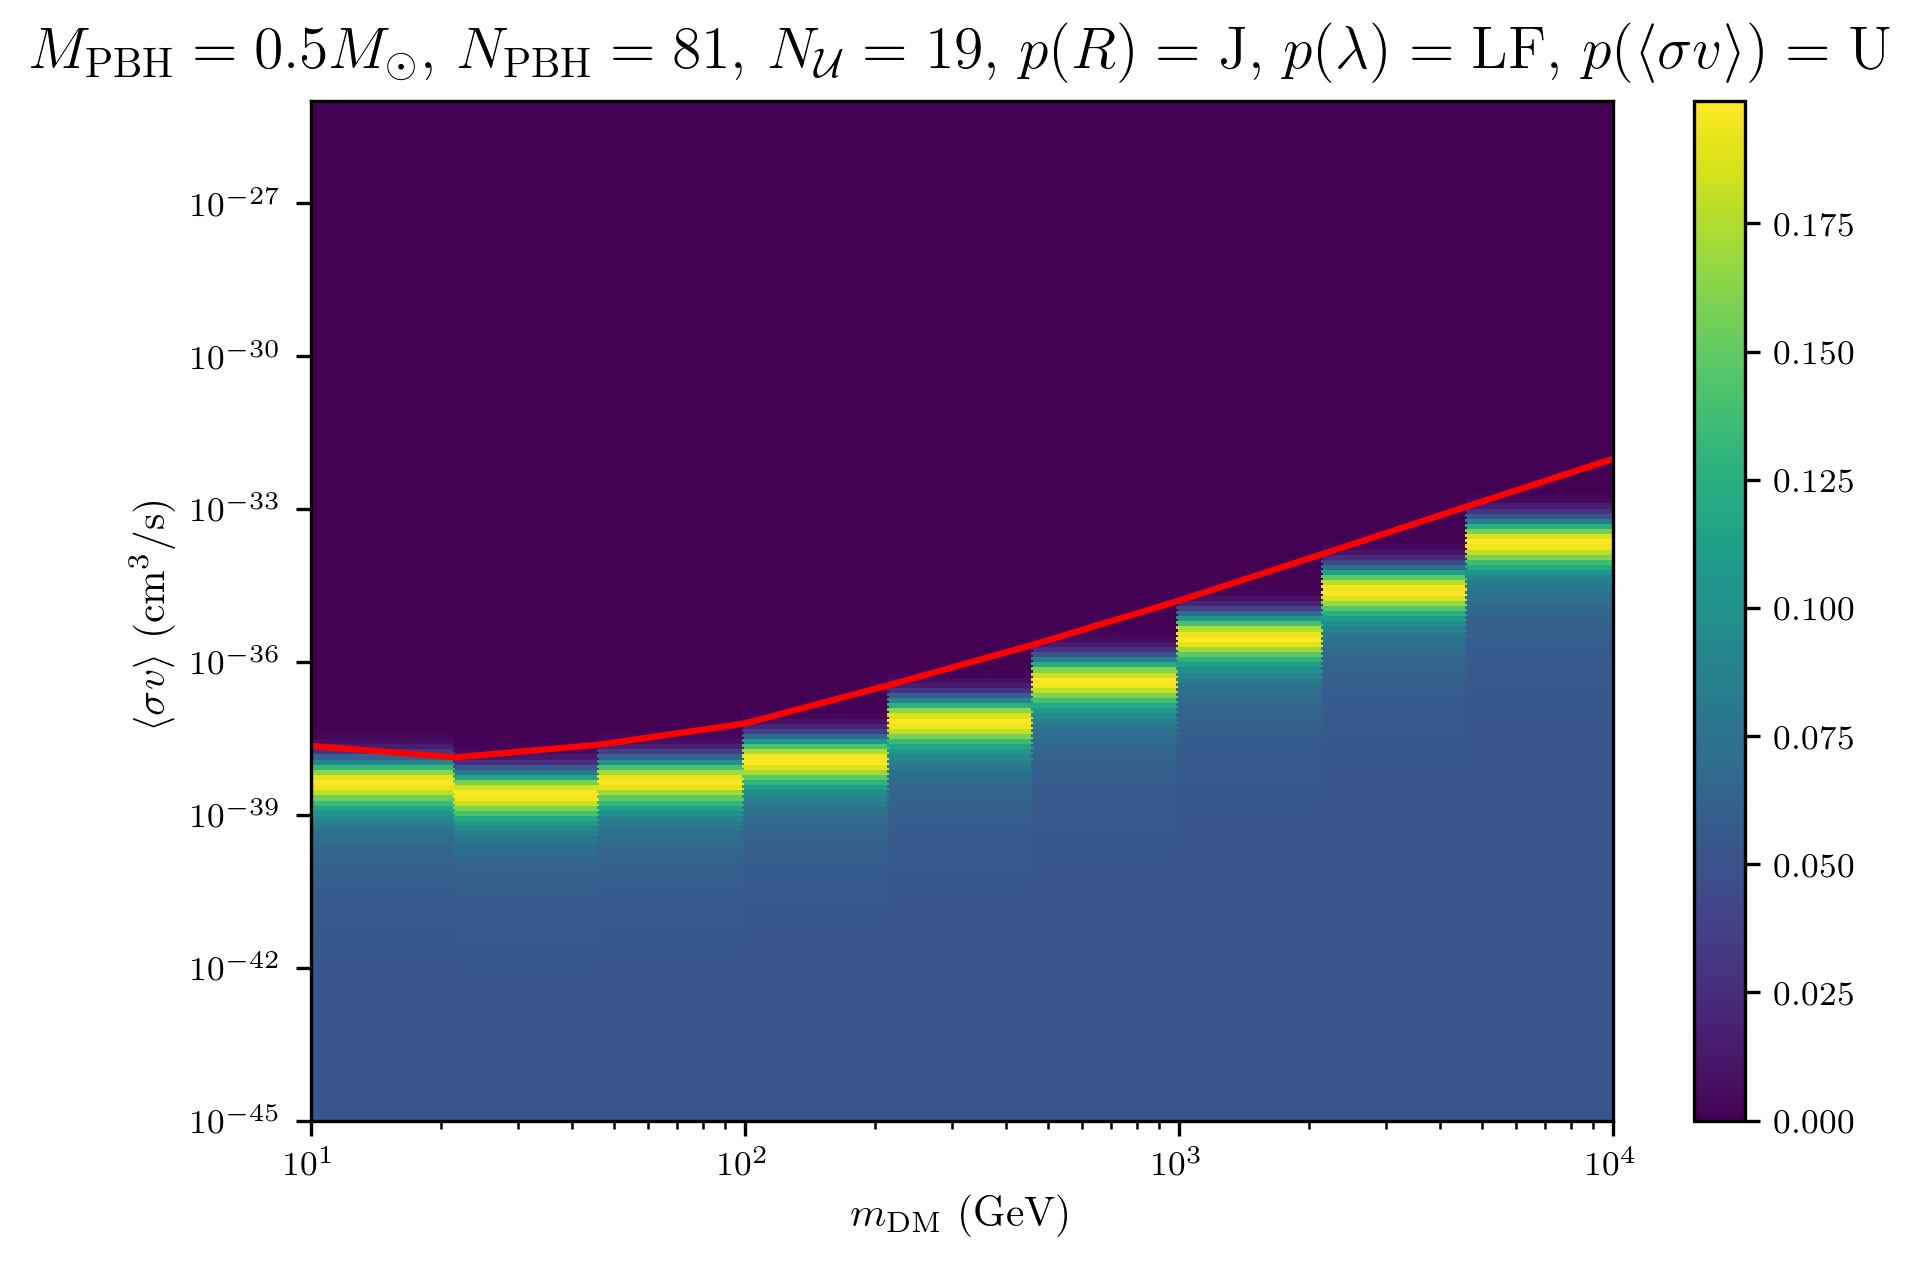

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))

ax.set_xlim(m_dms[[0, -1]])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
ax.set_ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
ax.set_title((r"$M_{\mathrm{PBH}}=%.1f M_\odot$, "
              r"$N_{\mathrm{PBH}}=%i$, "
              r"$N_{\mathcal{U}}=%i$, "
              r"$p(R)=\mathrm{%s}$, $p(\lambda)=\mathrm{%s}$, $p(\langle \sigma v \rangle)=\mathrm{%s}$") %
             (m_pbh, n_pbh, n_u_0, merger_rate_prior, lambda_prior, sv_prior))

# Posterior
m_dm_mg, sv_mg = np.meshgrid(m_dms, svs)
post_pcmesh = ax.pcolormesh(m_dm_mg, sv_mg, post_un_vals, edgecolor="face")
fig.colorbar(post_pcmesh)

# Point-source bound
ax.plot(m_dms, sv_bounds, 'r')
# Diffuse bound
# ax.plot(m_dms, sv_bound_diffuse(m_dms, m_pbh, f_map), '--c')
# Gambit contours

# for gm, c in zip(gambit_models, colors):
#     plot_gambit_contour(gm, ax, color=c)

# fig.savefig(
#     "figures/sv_bounds/post_sv_M={:.1f}_N={}_prior_rate={}_prior_lambda={}_prior_sv={}.pdf".format(
#     m_pbh, n_pbh, merger_rate_prior, lambda_prior, sv_prior))

# Compare bounds for different $M_{\mathrm{PBH}}$

In [13]:
n_pbh = 1
m_pbhs = np.arange(0.2, 1.1, 0.1)
bounds = {}
for m_pbh in m_pbhs:
    m_dms, cur_bound = np.loadtxt("data/bounds/sv_bounds_M={:.1f}_N={}.csv".format(m_pbh, n_pbh)).T
    bounds[m_pbh] = cur_bound

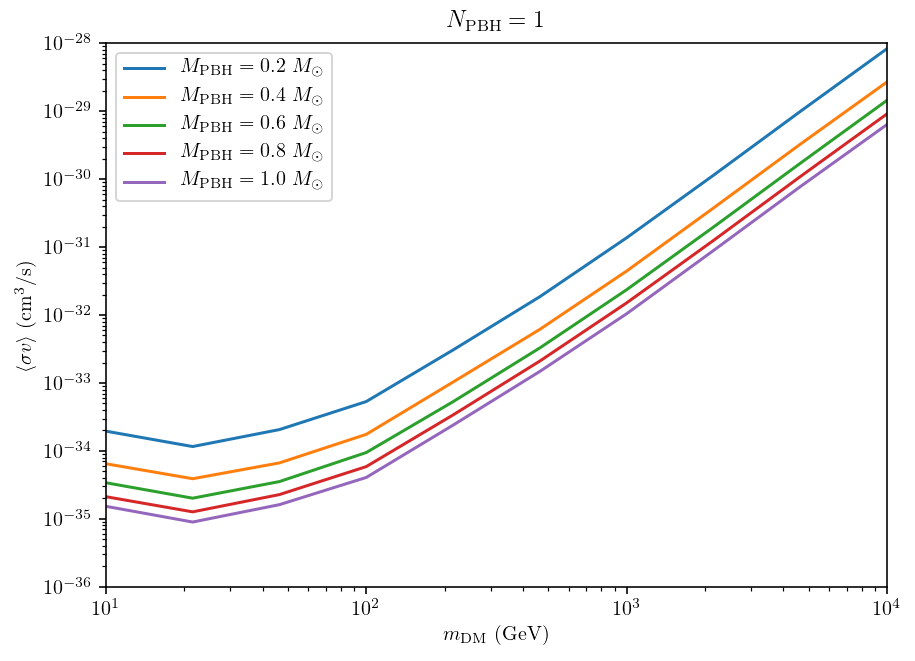

In [28]:
fig, ax = plt.subplots(figsize=(7, 5))

for m_pbh in m_pbhs[::2]:
    ax.plot(m_dms, bounds[m_pbh], label=r"$M_{\mathrm{PBH}} = %.1f~M_\odot$" % m_pbh)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(m_dms[[0, -1]])
ax.set_ylim(1e-36, 1e-28)
ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
ax.set_ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
ax.set_title(r"$N_{\mathrm{PBH}}=%i$" % n_pbh)
ax.legend()
fig.savefig("figures/sv_bounds/N={}.pdf".format(n_pbh))

# Compare bounds for different $N_{\mathrm{PBH}}$

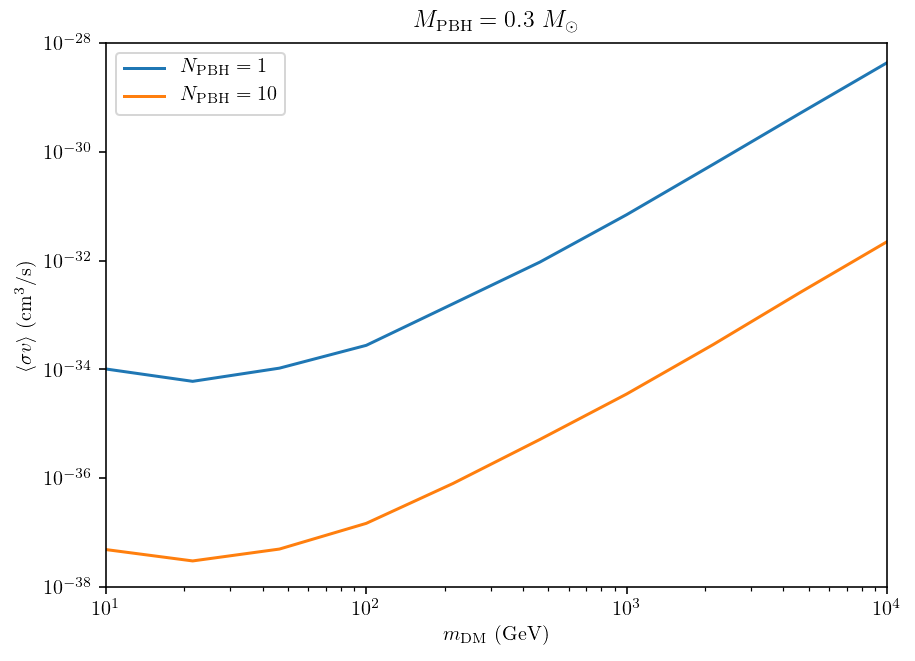

In [29]:
m_pbh = 0.3
m_dms, bound_1 = np.loadtxt("data/bounds/sv_bounds_M={:.1f}_N={}.csv".format(m_pbh, 1)).T
m_dms, bound_10 = np.loadtxt("data/bounds/sv_bounds_M={:.1f}_N={}.csv".format(m_pbh, 10)).T

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(m_dms, bound_1, label=r"$N_{\mathrm{PBH}}=1$")
ax.plot(m_dms, bound_10, label=r"$N_{\mathrm{PBH}}=10$")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(m_dms[[0, -1]])
ax.set_ylim(1e-38, 1e-28)
ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
ax.set_ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
ax.set_title(r"$M_{\mathrm{PBH}} = %.1f~M_\odot$" % m_pbh)
ax.legend()

fig.savefig("figures/sv_bounds/M={:.1f}.pdf".format(m_pbh))

# How close does a PBH need to be from earth to be detectable?

Should make sure it actually appears point-like

In [8]:
sim = PBHHaloSim(mass_dist=0.3, f_pbh=1e-2, m_dm = 20, sv=2e-38, n_samples=1000)
sim.run()
# Max distance at which gamma rays from the PBH would be detectable
d_det_max = np.sqrt(sim._flux_helper(sim.ann_rates[0], sim.flux_fact, 1.) / sim.flux_thresh)

Text(0.5, 1.0, 'UCMH tidal radii')

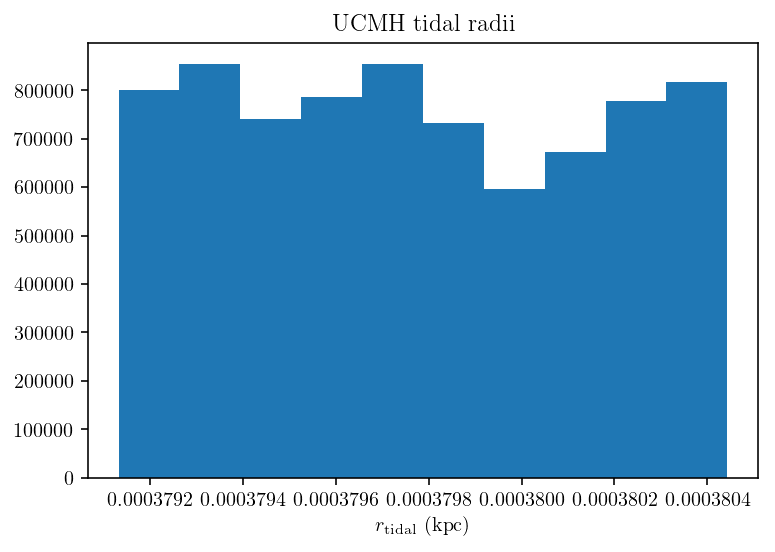

In [19]:
r_tidals = sim.positions_abs[0] * (sim.mass_dist / m_mw_dm)**(1/3)
plt.hist(r_tidals, density=True)

plt.xlabel(r"$r_{\mathrm{tidal}}$ (kpc)")
plt.title("UCMH tidal radii")

Text(0.5, 1.0, 'UCMH distances from Earth')

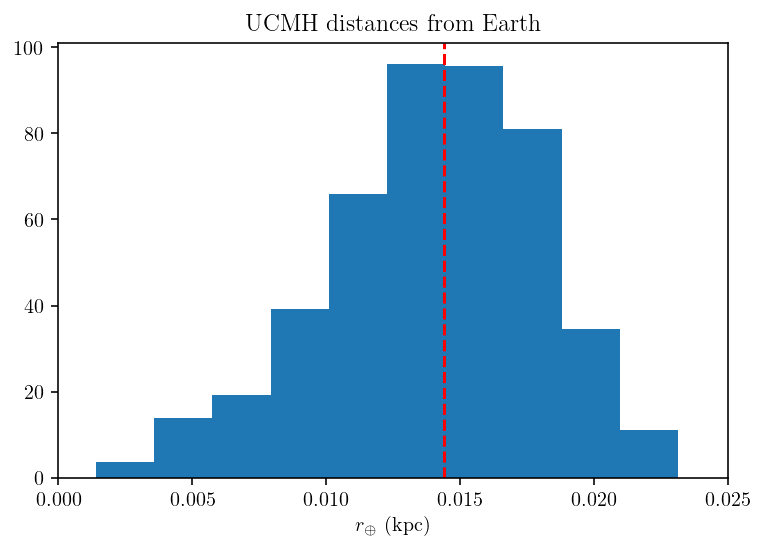

In [22]:
plt.hist(sim.positions[0], density=True)
plt.axvline(d_det_max, color='r', linestyle='--')

plt.xlabel(r"$r_{\oplus}$ (kpc)")
plt.xlim(0, 0.025)
plt.title("UCMH distances from Earth")

The UCMH distances are at least an order of magnitude larger than the tidal radii, so I'd say we're safe.